# 서울시 요식업 평균 매출 예측 모델
서울시 요식업 매출 데이터 분석 및 예측 모델 구축

## 1. 데이터 로딩과 전처리

### 1.1 라이브러리 임포트

In [104]:
# 데이터 분석 및 시각화 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 머신러닝 모델링 라이브러리
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# 결과 저장 디렉토리 생성
Path('plots').mkdir(exist_ok=True)
Path('models').mkdir(exist_ok=True)

### 1.2 데이터 로드

In [105]:
# 데이터셋 로드
sales_df = pd.read_csv("data/서울시 상권분석서비스(추정매출-상권).csv", encoding="cp949")
work_df = pd.read_csv("data/서울시 상권분석서비스(직장인구-상권).csv", encoding="cp949")
street_df = pd.read_csv("data/서울시 상권분석서비스(길단위인구-상권).csv", encoding="cp949")

### 1.3 데이터 기본 정보 확인

In [106]:
# 데이터셋 크기 확인
print("\n=== 데이터셋 기본 정보 ===")
print(f"매출 데이터: {sales_df.shape[0]:,}행, {sales_df.shape[1]}열")
print(f"직장인구 데이터: {work_df.shape[0]:,}행, {work_df.shape[1]}열")
print(f"유동인구 데이터: {street_df.shape[0]:,}행, {street_df.shape[1]}열")


=== 데이터셋 기본 정보 ===
매출 데이터: 87,179행, 55열
직장인구 데이터: 6,549행, 26열
유동인구 데이터: 6,595행, 27열


### 1.4 매출 데이터 확인

In [107]:
# 데이터 샘플 및 컬럼 확인
print("\n=== 매출 데이터 샘플 ===")
print(sales_df.head(3))
print("\n=== 매출 데이터 컬럼 목록 ===")
print(sales_df.columns.tolist())


=== 매출 데이터 샘플 ===
   기준_년분기_코드 상권_구분_코드 상권_구분_코드_명    상권_코드   상권_코드_명 서비스_업종_코드 서비스_업종_코드_명  \
0      20241        U       관광특구  3001491  이태원 관광특구  CS100001       한식음식점   
1      20241        U       관광특구  3001491  이태원 관광특구  CS100002       중식음식점   
2      20241        U       관광특구  3001491  이태원 관광특구  CS100003       일식음식점   

       당월_매출_금액  당월_매출_건수      주중_매출_금액  ...  시간대_건수~21_매출_건수  \
0  1.185751e+10    254192  6.640829e+09  ...            69016   
1  1.911647e+09     46140  1.259317e+09  ...            18085   
2  7.273213e+08     10811  4.611840e+08  ...             3596   

   시간대_건수~24_매출_건수  남성_매출_건수  여성_매출_건수  연령대_10_매출_건수  연령대_20_매출_건수  \
0            38472    129419    109336          1277         73116   
1             4918     21479     21646           151         14443   
2             2734      4855      4682            52          2911   

   연령대_30_매출_건수  연령대_40_매출_건수  연령대_50_매출_건수  연령대_60_이상_매출_건수  
0         86124         33511         28074            16652  
1   

### 1.5 결측치 및 요식업 코드 확인

In [108]:
# 결측치 확인
print("\n=== 결측치 확인 ===")
missing_sales = sales_df.isnull().sum()
missing_sales = missing_sales[missing_sales > 0]
if len(missing_sales) > 0:
    print("매출 데이터 결측치:")
    print(missing_sales)
else:
    print("매출 데이터에 결측치가 없습니다.")

# 요식업(CS1) 코드 분포 확인
print("\n=== 요식업 서비스 코드 분포 ===")
cs1_codes_count = sales_df["서비스_업종_코드"].str.startswith("CS1").value_counts()
print(f"요식업(CS1) 서비스 코드 수: {cs1_codes_count.get(True, 0):,}/{len(sales_df):,}")


=== 결측치 확인 ===
매출 데이터에 결측치가 없습니다.

=== 요식업 서비스 코드 분포 ===
요식업(CS1) 서비스 코드 수: 27,095/87,179


### 1.6 요식업 데이터 필터링

In [109]:
# 요식업(CS1) 데이터만 추출하기
restaurant_sales = sales_df[sales_df["서비스_업종_코드"].str.startswith("CS1")].copy()
print(f"\n요식업(CS1) 데이터 추출: {len(restaurant_sales):,}행")

# 업종 분포 확인
if '서비스_업종_코드_명' in restaurant_sales.columns:
    print("\n=== 요식업 유형 분포 (상위 10개) ===")
    print(restaurant_sales['서비스_업종_코드_명'].value_counts().head(10))


요식업(CS1) 데이터 추출: 27,095행

=== 요식업 유형 분포 (상위 10개) ===
서비스_업종_코드_명
한식음식점      5645
커피-음료      4348
호프-간이주점    3641
분식전문점      3224
치킨전문점      2196
중식음식점      1839
제과점        1719
패스트푸드점     1718
일식음식점      1396
양식음식점      1369
Name: count, dtype: int64


### 1.7 상권별 평균 매출 계산

In [110]:
# 상권별, 분기별 평균매출 계산
grouped_sales = restaurant_sales.groupby(["상권_코드_명", "기준_년분기_코드"])[["당월_매출_금액"]].mean().reset_index()
grouped_sales.rename(columns={"당월_매출_금액": "평균매출"}, inplace=True)

# 상권 구분 코드 추출 (상권별로 고유한 값)
commercial_type_codes = sales_df[["상권_코드_명", "상권_구분_코드_명"]].drop_duplicates()

# 평균매출 데이터에 상권 구분 코드 병합
grouped_sales = pd.merge(grouped_sales, commercial_type_codes, on="상권_코드_명", how="left")

# 평균매출 통계 확인
print("\n=== 평균매출 기본 통계량 ===")
print(grouped_sales["평균매출"].describe())


=== 평균매출 기본 통계량 ===
count    5.915000e+03
mean     6.709910e+08
std      1.154353e+09
min      1.424950e+05
25%      1.727753e+08
50%      3.506407e+08
75%      6.727847e+08
max      1.964679e+10
Name: 평균매출, dtype: float64


### 1.8 매출 분포 시각화

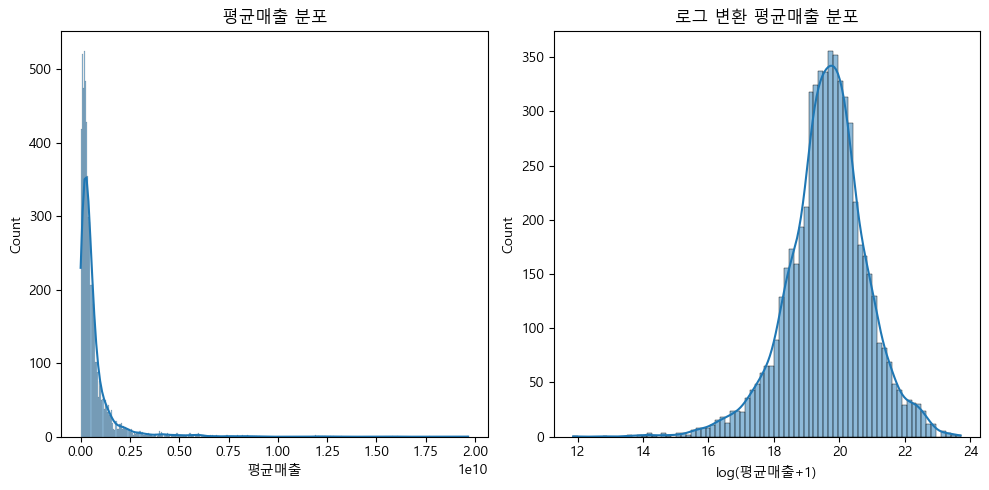

In [111]:
# 평균매출 분포 시각화
plt.figure(figsize=(10, 5))

# 원본 매출 분포
plt.subplot(1, 2, 1)
sns.histplot(grouped_sales["평균매출"], kde=True)
plt.title("평균매출 분포")
plt.xlabel("평균매출")

# 로그 변환 매출 분포 (log(x+1)로 변환하여 0값 처리)
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(grouped_sales["평균매출"]), kde=True)
plt.title("로그 변환 평균매출 분포")
plt.xlabel("log(평균매출+1)")

plt.tight_layout()
plt.savefig('plots/sales_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 1.9 데이터 병합

In [112]:
# 매출, 유동인구, 직장인구 데이터 병합
# 먼저 매출데이터(grouped_sales)와 유동인구 데이터(street_df) 병합
restaurant_data = pd.merge(grouped_sales, street_df, on=["상권_코드_명", "기준_년분기_코드"], how="left")

# 그 다음 직장인구 데이터(work_df) 병합
restaurant_data = pd.merge(restaurant_data, work_df, on=["상권_코드_명", "기준_년분기_코드"], how="left")

# 병합 결과 확인
print("\n=== 병합 결과 확인 ===")
print(f"병합 후 데이터: {restaurant_data.shape[0]:,}행, {restaurant_data.shape[1]:,}열")
print(f"원본 평균매출 데이터: {grouped_sales.shape[0]:,}행, {grouped_sales.shape[1]:,}열")

# 결측치 확인
missing_after_merge = restaurant_data.isnull().sum().sum()
missing_percent = (missing_after_merge / (restaurant_data.shape[0] * restaurant_data.shape[1])) * 100
print(f"병합 후 총 결측치: {missing_after_merge:,}개 ({missing_percent:.2f}%)")


=== 병합 결과 확인 ===
병합 후 데이터: 5,915행, 53열
원본 평균매출 데이터: 5,915행, 4열
병합 후 총 결측치: 653개 (0.21%)


### 1.10 병합 결과 확인

In [113]:
# 병합 결과 샘플 출력
print("\n=== 병합 결과 샘플 ===")
sample_cols = ['상권_코드_명', '기준_년분기_코드', '상권_구분_코드_명', '평균매출']
# 유동인구, 직장인구 컬럼이 있으면 출력 컬럼에 추가
if '총_유동인구_수' in restaurant_data.columns:
    sample_cols.append('총_유동인구_수')
if '총_직장_인구_수' in restaurant_data.columns:
    sample_cols.append('총_직장_인구_수')
print(restaurant_data[sample_cols].head(3))


=== 병합 결과 샘플 ===
        상권_코드_명  기준_년분기_코드 상권_구분_코드_명         평균매출   총_유동인구_수  총_직장_인구_수
0  4.19민주묘지역 2번      20241       골목상권  579173781.5  1021175.0      164.0
1  4.19민주묘지역 2번      20242       골목상권  647617846.2  1065757.0      164.0
2  4.19민주묘지역 2번      20243       골목상권  578556573.8   981924.0      164.0


### 1.11 결측치 처리

In [114]:
# 결측치 처리
# 수치형 컬럼은 중앙값으로 대체 (이상치에 덜 민감)
numeric_cols = restaurant_data.select_dtypes(include=['number']).columns
for col in numeric_cols:
    if restaurant_data[col].isnull().any():
        restaurant_data[col] = restaurant_data[col].fillna(restaurant_data[col].median())

# 문자열 컬럼은 최빈값으로 대체
object_cols = restaurant_data.select_dtypes(include=['object']).columns
for col in object_cols:
    if restaurant_data[col].isnull().any():
        # 최빈값이 없는 경우 '알수없음'으로 대체
        mode_value = restaurant_data[col].mode().iloc[0] if not restaurant_data[col].mode().empty else "알수없음"
        restaurant_data[col] = restaurant_data[col].fillna(mode_value)

## 2. 특성 엔지니어링

### 2.0 특성 정의

In [115]:
# 모델링에 사용할 특성 정의
numeric_features = [
    "총_유동인구_수", "남성_유동인구_수", "여성_유동인구_수", 
    "총_직장_인구_수", "남성_직장_인구_수", "여성_직장_인구_수", 
    "초년_유동인구_수", "중년_유동인구_수", "노년_유동인구_수", 
    "초년_직장_인구_수", "중년_직장_인구_수", "노년_직장_인구_수"
]

# 범주형 특성 - 원핫인코딩 될 변수들
categorical_features = ["상권_구분_코드_명", "기준_년분기_코드"]

### 2.1 연령대별 인구 통합 특성

In [116]:
# 연령대 그룹핑 (초년(10-20대)/중년(30-40대)/노년(50대 이상))
# 유동인구 연령대별 통합
restaurant_data["초년_유동인구_수"] = restaurant_data["연령대_10_유동인구_수"] + restaurant_data["연령대_20_유동인구_수"]
restaurant_data["중년_유동인구_수"] = restaurant_data["연령대_30_유동인구_수"] + restaurant_data["연령대_40_유동인구_수"]
restaurant_data["노년_유동인구_수"] = restaurant_data["연령대_50_유동인구_수"] + restaurant_data["연령대_60_이상_유동인구_수"]

# 직장인구 연령대별 통합
restaurant_data["초년_직장_인구_수"] = restaurant_data["연령대_10_직장_인구_수"] + restaurant_data["연령대_20_직장_인구_수"]
restaurant_data["중년_직장_인구_수"] = restaurant_data["연령대_30_직장_인구_수"] + restaurant_data["연령대_40_직장_인구_수"]
restaurant_data["노년_직장_인구_수"] = restaurant_data["연령대_50_직장_인구_수"] + restaurant_data["연령대_60_이상_직장_인구_수"]

### 2.2 성별 인구 비율 계산

In [117]:
# 성별 인구 비율 계산 (총 인구 대비 각 성별 비율)
restaurant_data['남성_유동인구_비율'] = restaurant_data['남성_유동인구_수'] / restaurant_data['총_유동인구_수']
restaurant_data['여성_유동인구_비율'] = restaurant_data['여성_유동인구_수'] / restaurant_data['총_유동인구_수']
restaurant_data['남성_직장인구_비율'] = restaurant_data['남성_직장_인구_수'] / restaurant_data['총_직장_인구_수']
restaurant_data['여성_직장인구_비율'] = restaurant_data['여성_직장_인구_수'] / restaurant_data['총_직장_인구_수']

# 0으로 나누는 경우(분모가 0인 경우) 처리
for col in ['남성_유동인구_비율', '여성_유동인구_비율', '남성_직장인구_비율', '여성_직장인구_비율']:
    restaurant_data[col] = restaurant_data[col].fillna(0)

### 2.3 성별 분포 시각화

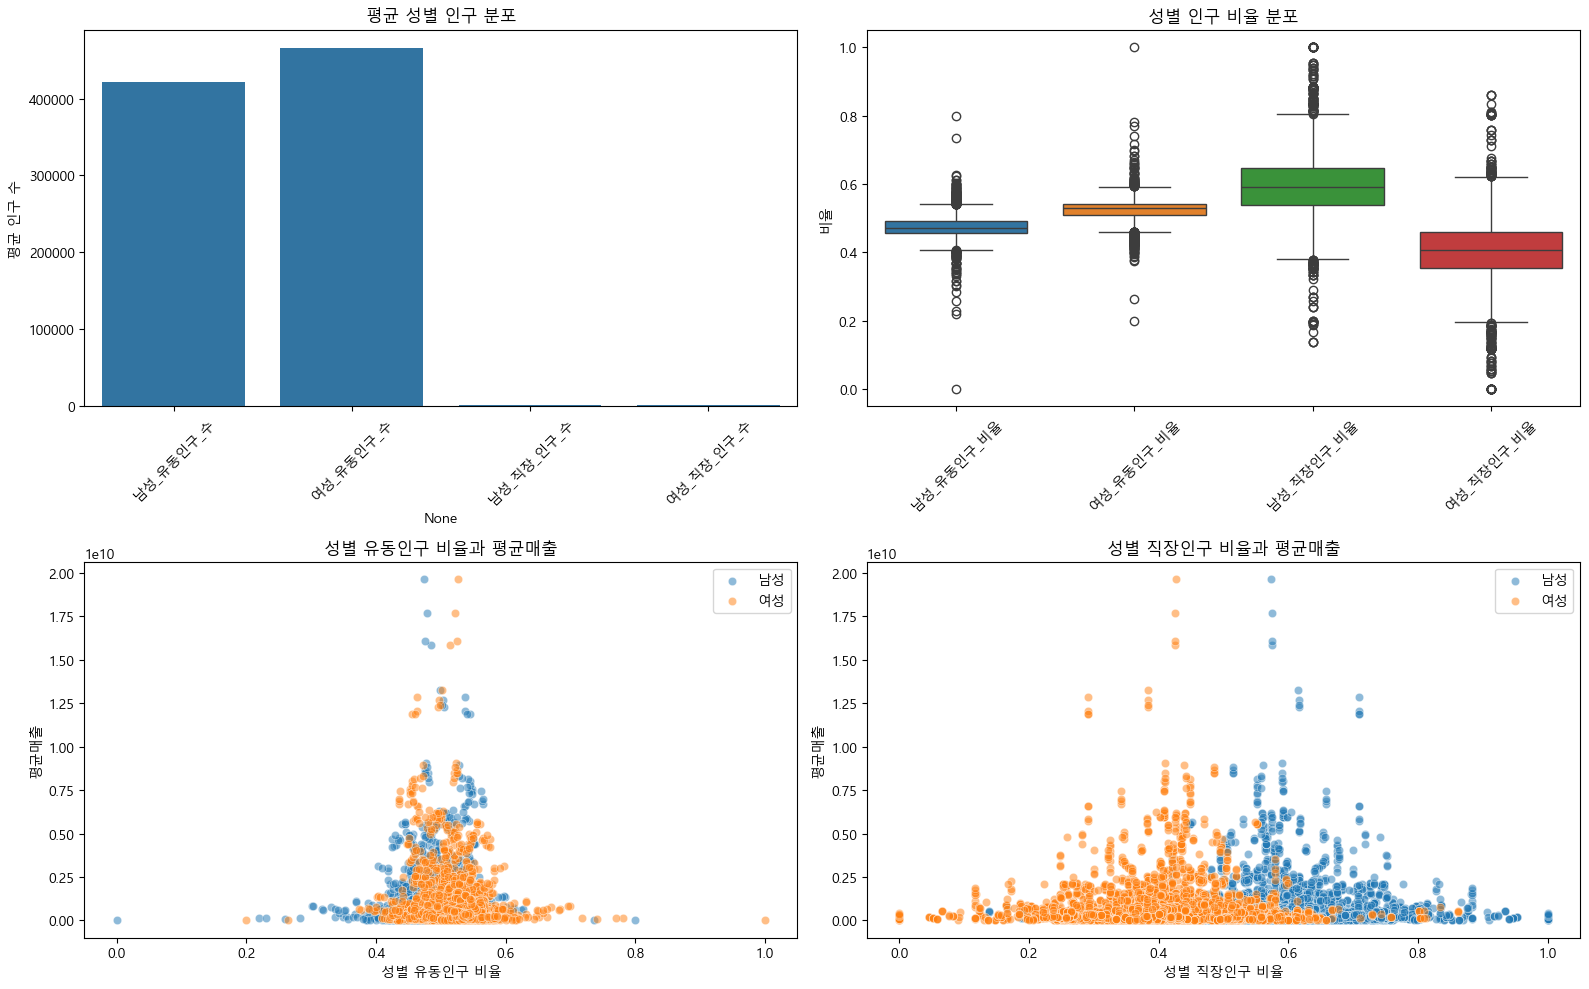

In [118]:
# 성별 인구 분포 시각화 (4개 그래프 그리기)
plt.figure(figsize=(16, 10))

# 1. 성별 인구 분포 (절대값)
plt.subplot(2, 2, 1)
gender_data = restaurant_data[['남성_유동인구_수', '여성_유동인구_수', '남성_직장_인구_수', '여성_직장_인구_수']].mean()
sns.barplot(x=gender_data.index, y=gender_data.values)
plt.title('평균 성별 인구 분포')
plt.ylabel('평균 인구 수')
plt.xticks(rotation=45)

# 2. 성별 비율 분포 - 박스플롯
plt.subplot(2, 2, 2)
gender_ratio_cols = ['남성_유동인구_비율', '여성_유동인구_비율', '남성_직장인구_비율', '여성_직장인구_비율']
sns.boxplot(data=restaurant_data[gender_ratio_cols])
plt.title('성별 인구 비율 분포')
plt.ylabel('비율')
plt.xticks(rotation=45)

# 3. 성별 유동인구 비율과 매출 관계 - 산점도
plt.subplot(2, 2, 3)
sns.scatterplot(x='남성_유동인구_비율', y='평균매출', data=restaurant_data, alpha=0.5, label='남성')
sns.scatterplot(x='여성_유동인구_비율', y='평균매출', data=restaurant_data, alpha=0.5, label='여성')
plt.title('성별 유동인구 비율과 평균매출')
plt.xlabel('성별 유동인구 비율')
plt.ylabel('평균매출')
plt.legend()

# 4. 성별 직장인구 비율과 매출 관계 - 산점도
plt.subplot(2, 2, 4)
sns.scatterplot(x='남성_직장인구_비율', y='평균매출', data=restaurant_data, alpha=0.5, label='남성')
sns.scatterplot(x='여성_직장인구_비율', y='평균매출', data=restaurant_data, alpha=0.5, label='여성')
plt.title('성별 직장인구 비율과 평균매출')
plt.xlabel('성별 직장인구 비율')
plt.ylabel('평균매출')
plt.legend()

plt.tight_layout()
plt.savefig('plots/gender_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.4 상권 유형 및 인구 분석

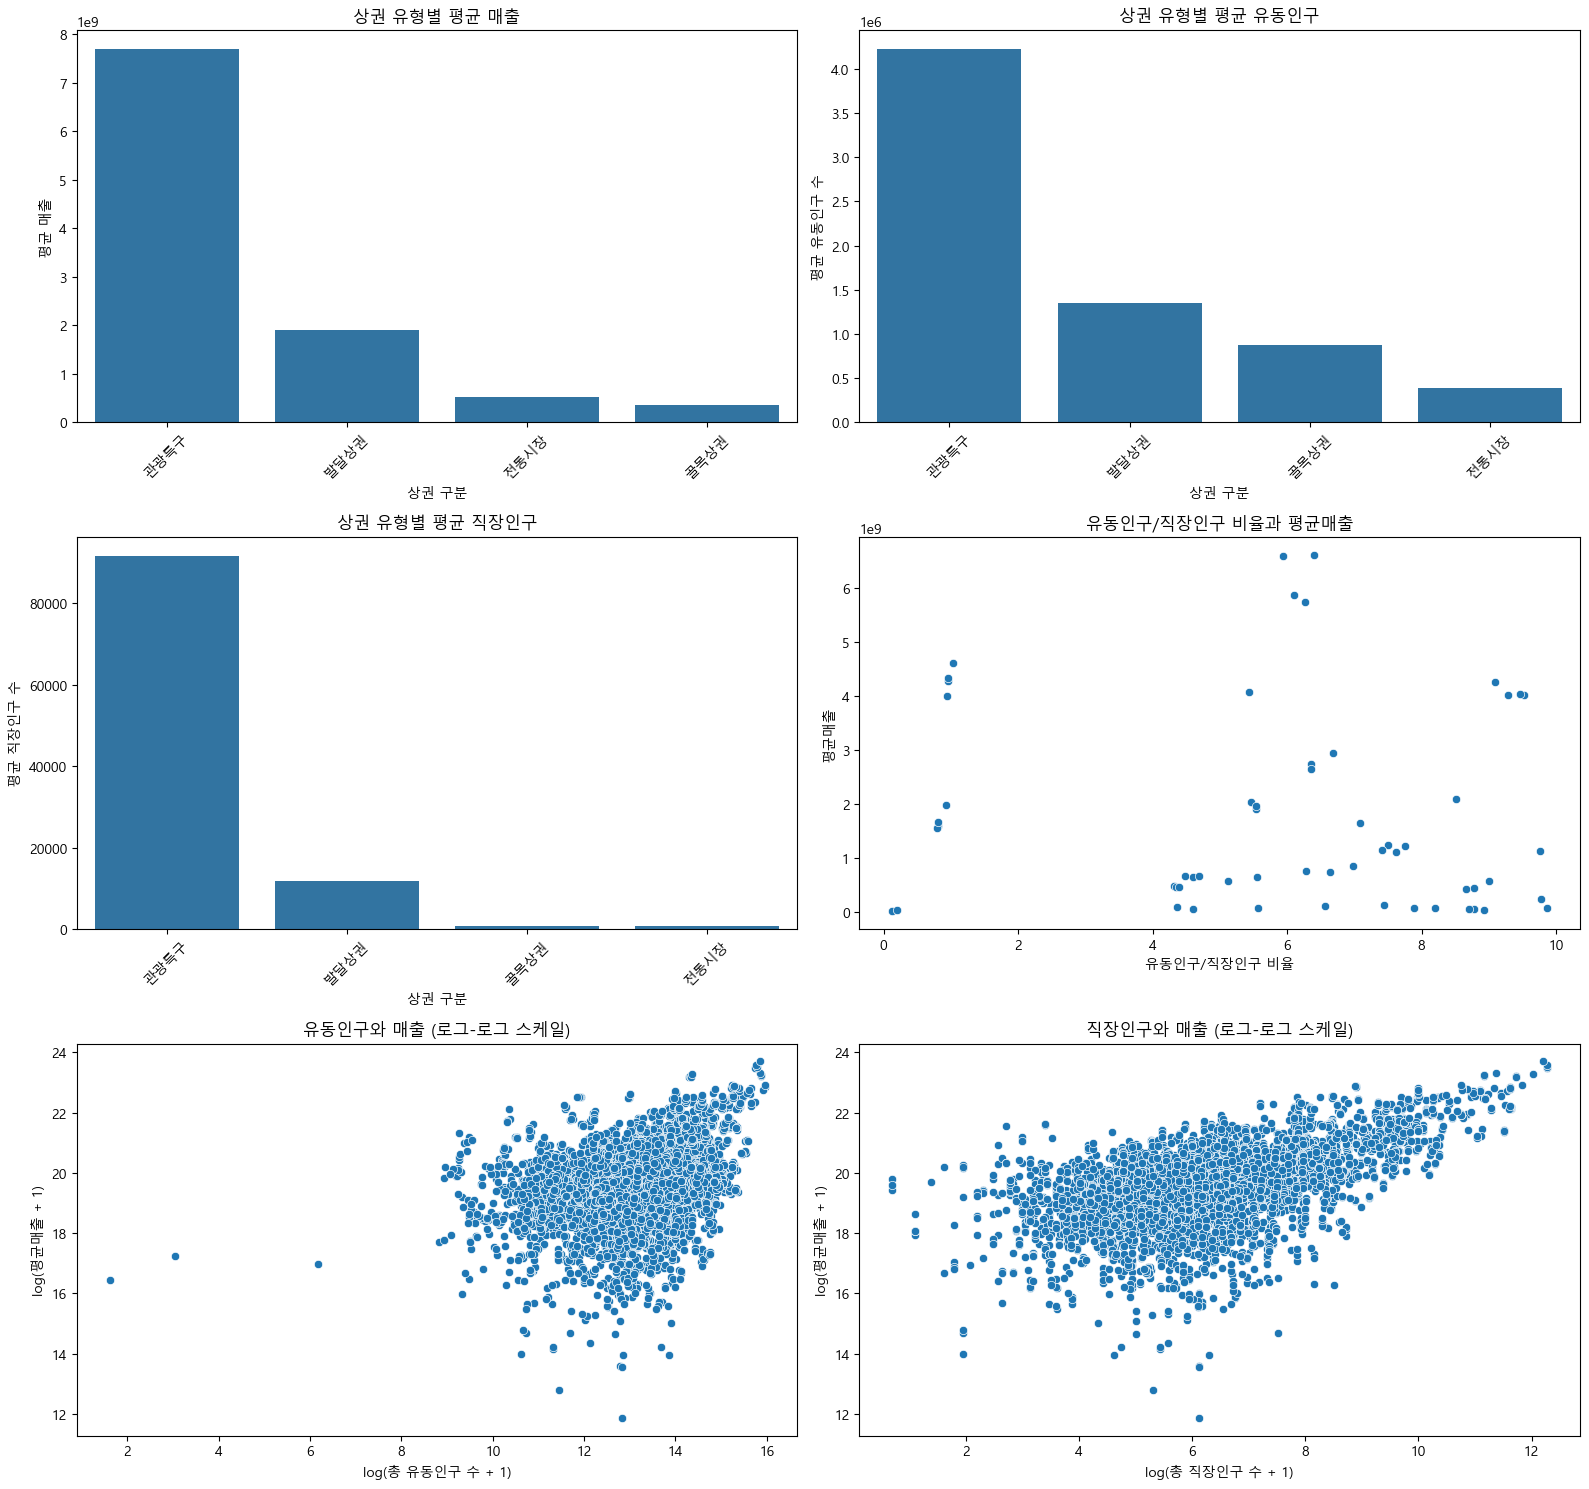

In [119]:
# 상권 유형별 인구 및 매출 분석 - 6개 그래프 그리기
plt.figure(figsize=(16, 15))

# 1. 상권 구분별 평균 매출 - 바 플롯
plt.subplot(3, 2, 1)
commercial_sales = restaurant_data.groupby('상권_구분_코드_명')['평균매출'].mean().sort_values(ascending=False).reset_index()
sns.barplot(x='상권_구분_코드_명', y='평균매출', data=commercial_sales)
plt.title('상권 유형별 평균 매출')
plt.xlabel('상권 구분')
plt.ylabel('평균 매출')
plt.xticks(rotation=45)

# 2. 상권 구분별 평균 유동인구 - 바 플롯
plt.subplot(3, 2, 2)
commercial_floating = restaurant_data.groupby('상권_구분_코드_명')['총_유동인구_수'].mean().sort_values(ascending=False).reset_index()
sns.barplot(x='상권_구분_코드_명', y='총_유동인구_수', data=commercial_floating)
plt.title('상권 유형별 평균 유동인구')
plt.xlabel('상권 구분')
plt.ylabel('평균 유동인구 수')
plt.xticks(rotation=45)

# 3. 상권 구분별 평균 직장인구 - 바 플롯
plt.subplot(3, 2, 3)
commercial_working = restaurant_data.groupby('상권_구분_코드_명')['총_직장_인구_수'].mean().sort_values(ascending=False).reset_index()
sns.barplot(x='상권_구분_코드_명', y='총_직장_인구_수', data=commercial_working)
plt.title('상권 유형별 평균 직장인구')
plt.xlabel('상권 구분')
plt.ylabel('평균 직장인구 수')
plt.xticks(rotation=45)

# 4. 유동인구/직장인구 비율과 매출 관계 - 산점도
plt.subplot(3, 2, 4)
# 유동인구/직장인구 비율 계산
restaurant_data['유동인구_직장인구_비율'] = restaurant_data['총_유동인구_수'] / restaurant_data['총_직장_인구_수']
# 무한값 처리 (0으로 나눈 경우)
restaurant_data['유동인구_직장인구_비율'] = restaurant_data['유동인구_직장인구_비율'].replace([np.inf, -np.inf], np.nan).fillna(0)
# 비율이 10 미만인 데이터만 시각화 (극단값 제외)
filtered_data = restaurant_data[restaurant_data['유동인구_직장인구_비율'] < 10]
sns.scatterplot(x='유동인구_직장인구_비율', y='평균매출', data=filtered_data)
plt.title('유동인구/직장인구 비율과 평균매출')
plt.xlabel('유동인구/직장인구 비율')
plt.ylabel('평균매출')

# 5. 유동인구와 매출 (로그 스케일) - 산점도
plt.subplot(3, 2, 5)
# 0보다 큰 값만 선택하여 로그 변환
non_zero_data = restaurant_data[(restaurant_data['총_유동인구_수'] > 0) & (restaurant_data['평균매출'] > 0)]
sns.scatterplot(x=np.log1p(non_zero_data['총_유동인구_수']), y=np.log1p(non_zero_data['평균매출']))
plt.title('유동인구와 매출 (로그-로그 스케일)')
plt.xlabel('log(총 유동인구 수 + 1)')
plt.ylabel('log(평균매출 + 1)')

# 6. 직장인구와 매출 (로그 스케일) - 산점도
plt.subplot(3, 2, 6)
# 0보다 큰 값만 선택하여 로그 변환
non_zero_data = restaurant_data[(restaurant_data['총_직장_인구_수'] > 0) & (restaurant_data['평균매출'] > 0)]
sns.scatterplot(x=np.log1p(non_zero_data['총_직장_인구_수']), y=np.log1p(non_zero_data['평균매출']))
plt.title('직장인구와 매출 (로그-로그 스케일)')
plt.xlabel('log(총 직장인구 수 + 1)')
plt.ylabel('log(평균매출 + 1)')

plt.tight_layout()
plt.savefig('plots/commercial_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.5 복합 특성 생성

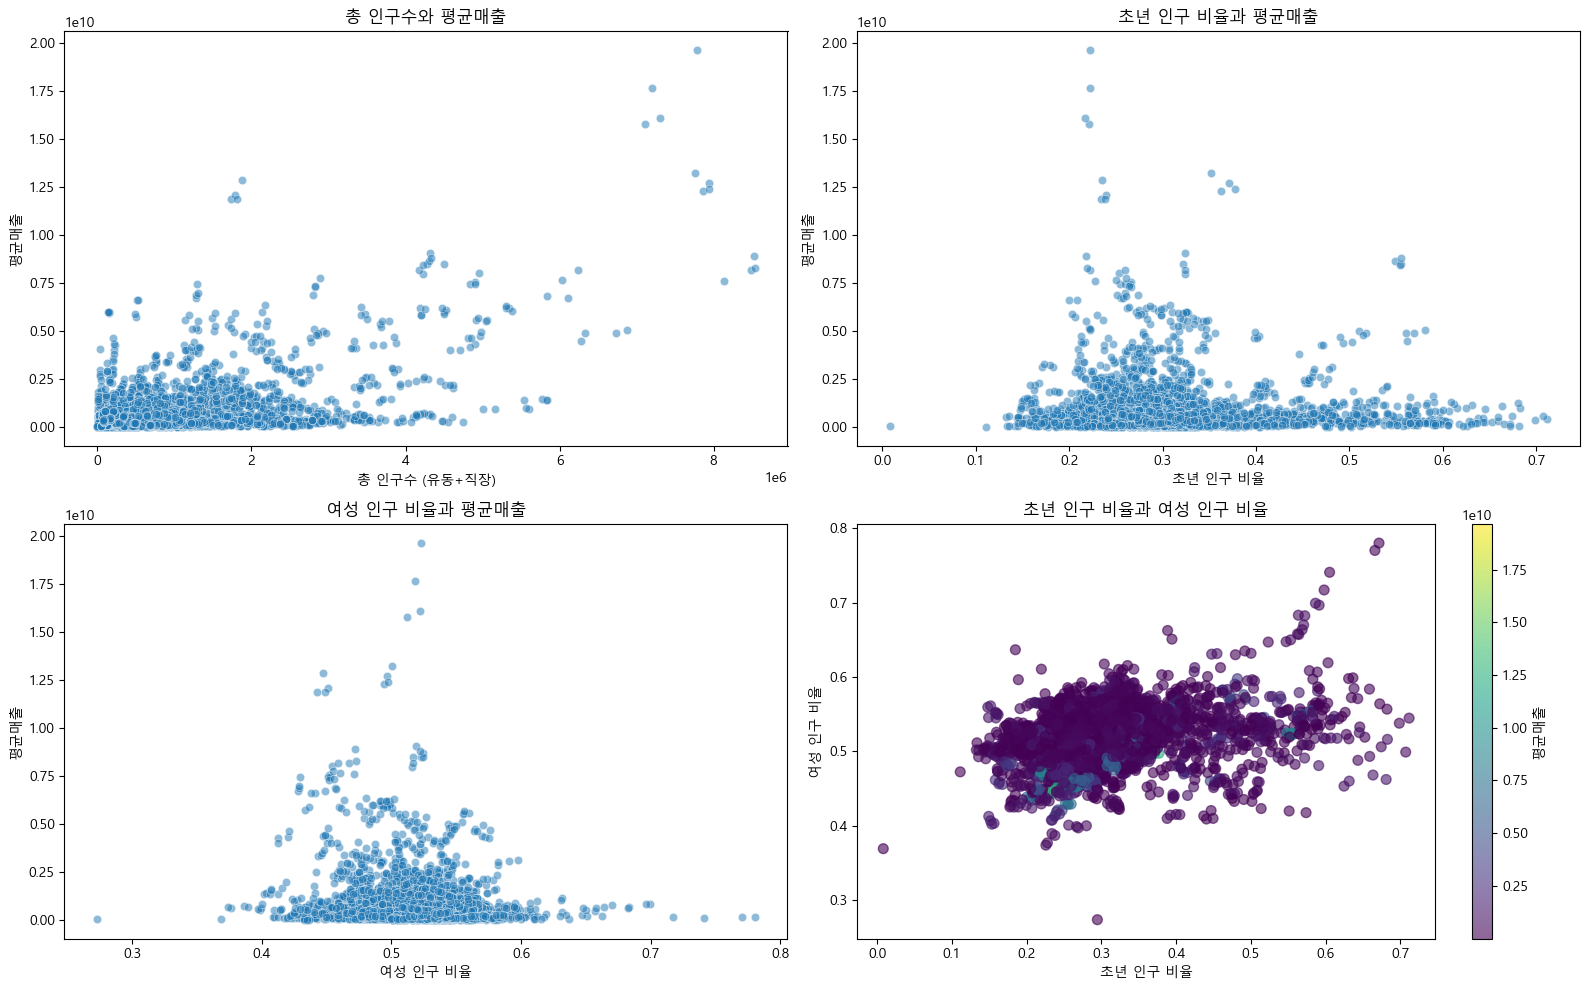

In [120]:
# 복합 특성 생성 및 시각화 - 4개 그래프
# 1. 총 인구 수 (유동+직장) 계산
restaurant_data['총_인구_수'] = restaurant_data['총_유동인구_수'] + restaurant_data['총_직장_인구_수']

# 2. 젊은층(초년) 비율 계산
restaurant_data['초년_인구_비율'] = (restaurant_data['초년_유동인구_수'] + restaurant_data['초년_직장_인구_수']) / restaurant_data['총_인구_수']
# 무한값 처리
restaurant_data['초년_인구_비율'] = restaurant_data['초년_인구_비율'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 3. 여성 비율 계산
restaurant_data['여성_인구_비율'] = (restaurant_data['여성_유동인구_수'] + restaurant_data['여성_직장_인구_수']) / restaurant_data['총_인구_수']
# 무한값 처리
restaurant_data['여성_인구_비율'] = restaurant_data['여성_인구_비율'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 복합 특성 시각화
plt.figure(figsize=(16, 10))

# 1. 총 인구수와 매출 관계 - 산점도
plt.subplot(2, 2, 1)
sns.scatterplot(x='총_인구_수', y='평균매출', data=restaurant_data, alpha=0.5)
plt.title('총 인구수와 평균매출')
plt.xlabel('총 인구수 (유동+직장)')
plt.ylabel('평균매출')

# 2. 초년 인구 비율과 매출 - 산점도
plt.subplot(2, 2, 2)
sns.scatterplot(x='초년_인구_비율', y='평균매출', data=restaurant_data, alpha=0.5)
plt.title('초년 인구 비율과 평균매출')
plt.xlabel('초년 인구 비율')
plt.ylabel('평균매출')

# 3. 여성 인구 비율과 매출 - 산점도
plt.subplot(2, 2, 3)
sns.scatterplot(x='여성_인구_비율', y='평균매출', data=restaurant_data, alpha=0.5)
plt.title('여성 인구 비율과 평균매출')
plt.xlabel('여성 인구 비율')
plt.ylabel('평균매출')

# 4. 초년 인구 비율과 여성 인구 비율 관계 - 산점도(컬러맵)
plt.subplot(2, 2, 4)
scatter = plt.scatter(restaurant_data['초년_인구_비율'], restaurant_data['여성_인구_비율'], 
                c=restaurant_data['평균매출'], cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='평균매출')
plt.title('초년 인구 비율과 여성 인구 비율')
plt.xlabel('초년 인구 비율')
plt.ylabel('여성 인구 비율')

plt.tight_layout()
plt.savefig('plots/population_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.6 수치형 특성 분포 확인

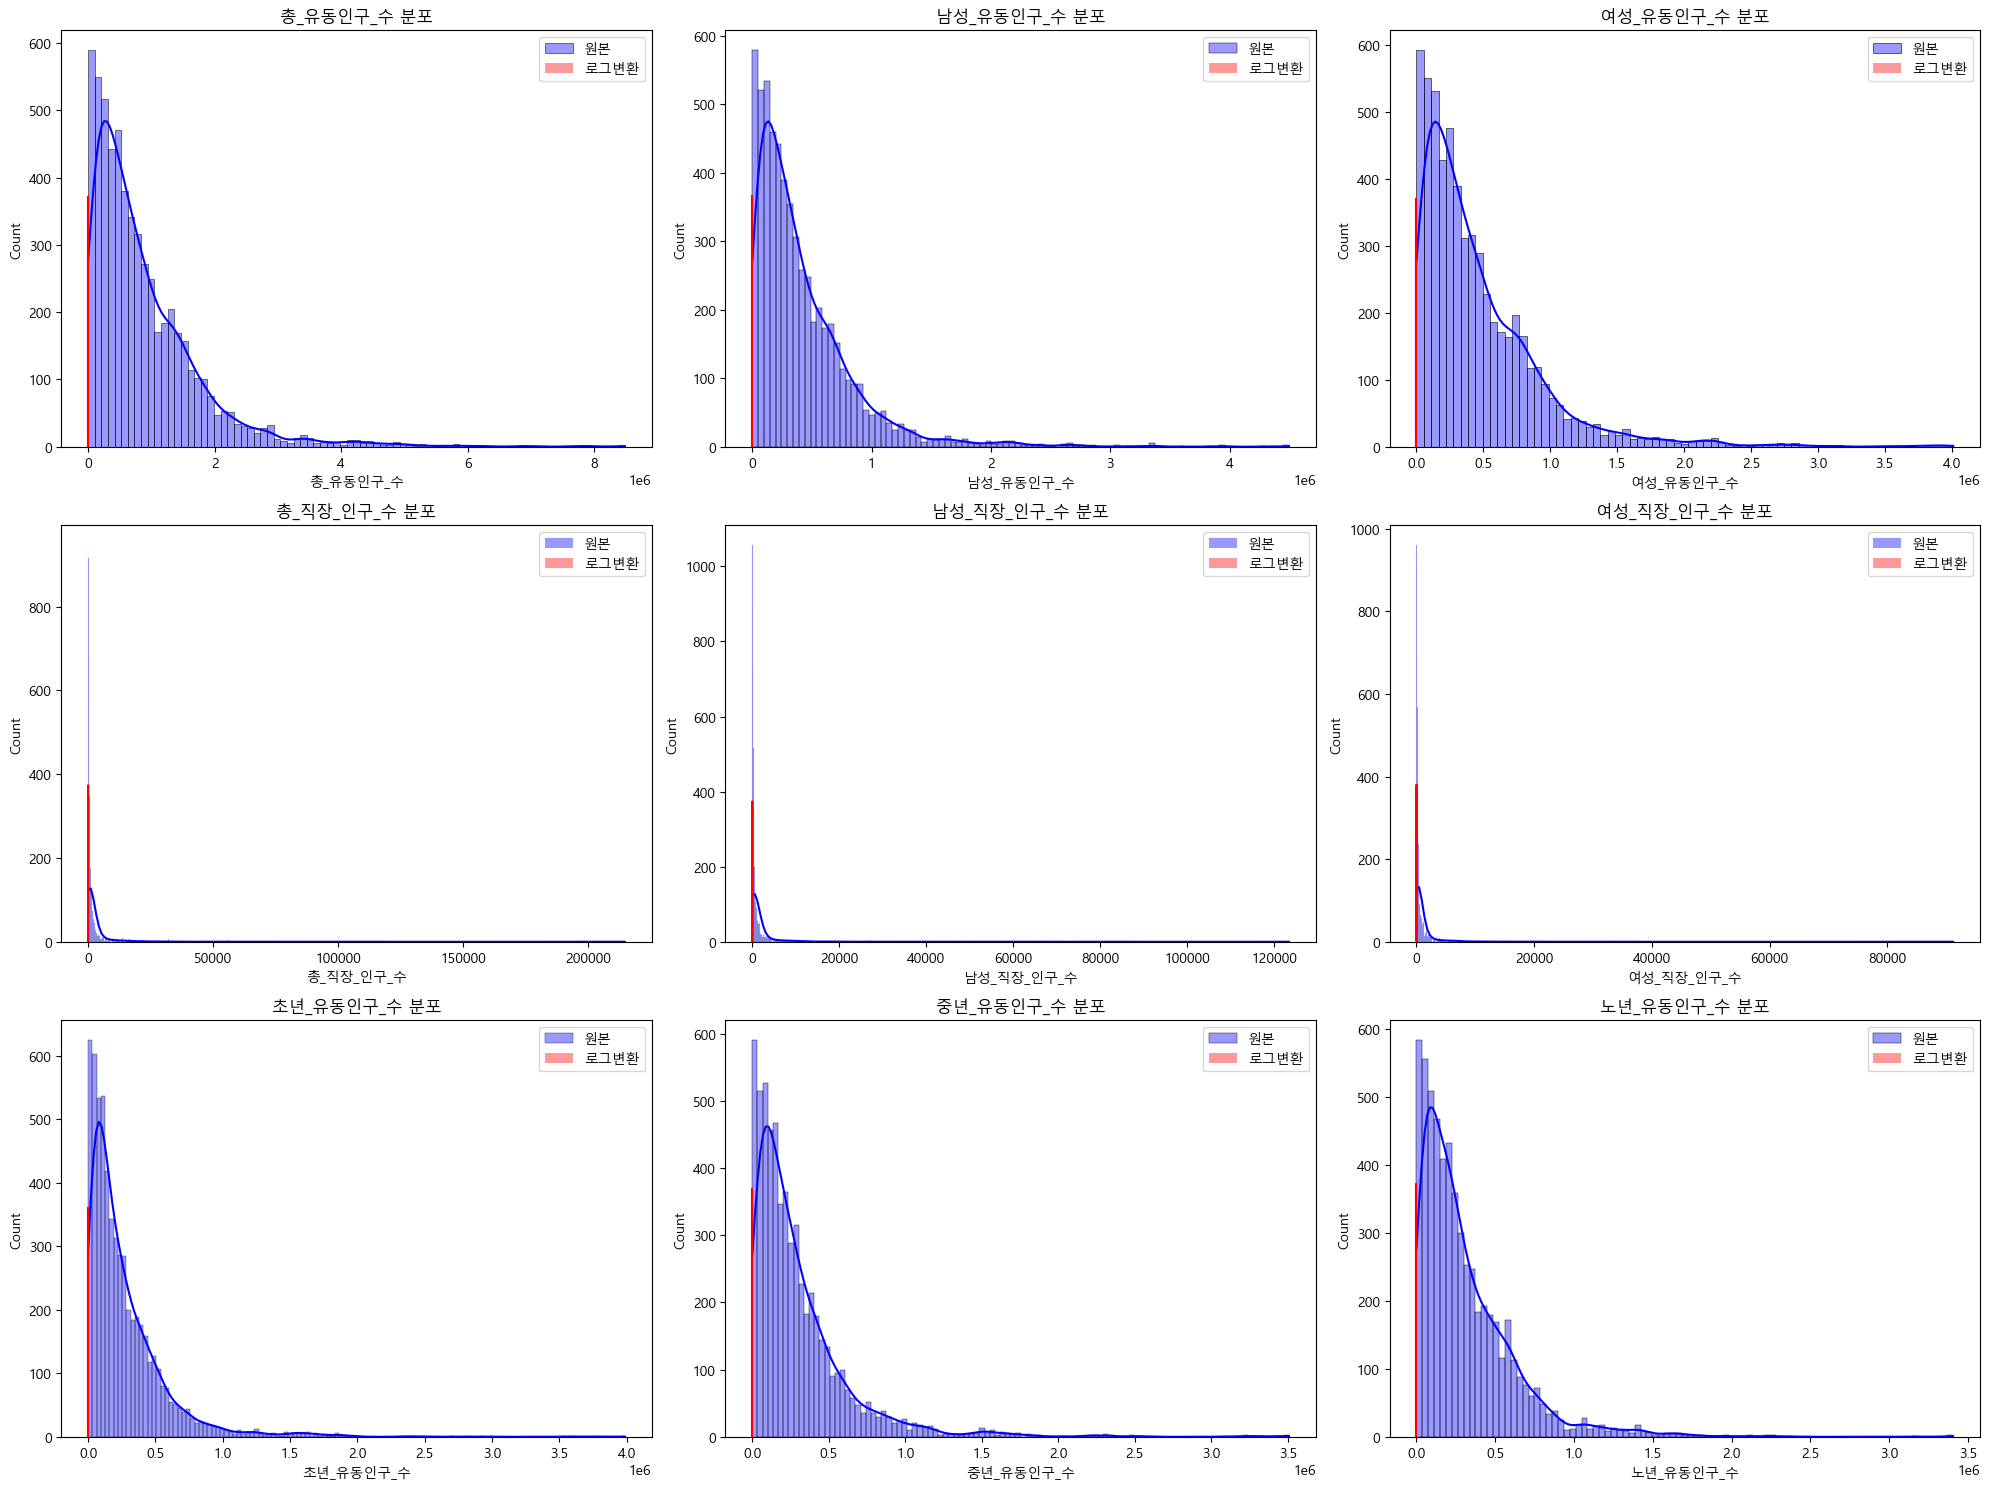

In [121]:
# 주요 수치형 특성 분포 - 9개 그래프
plt.figure(figsize=(20, 15))
# 주요 수치형 특성(최대 9개)의 분포 시각화
for i, feature in enumerate(numeric_features[:9]):
    plt.subplot(3, 3, i+1)
    # 원본 분포 히스토그램
    sns.histplot(restaurant_data[feature], kde=True, color='blue', alpha=0.4, label='원본')
    
    # 로그 변환 분포 히스토그램 (0보다 큰 값만)
    if (restaurant_data[feature] > 0).any():
        # 0값은 NaN으로 변환 후 제외하고 로그 변환
        log_data = np.log1p(restaurant_data[feature].replace(0, np.nan).dropna())
        sns.histplot(log_data, kde=True, color='red', alpha=0.4, label='로그변환')
    
    plt.title(f'{feature} 분포')
    plt.legend()

plt.tight_layout()
plt.savefig('plots/numeric_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.7 타겟-특성 관계 시각화

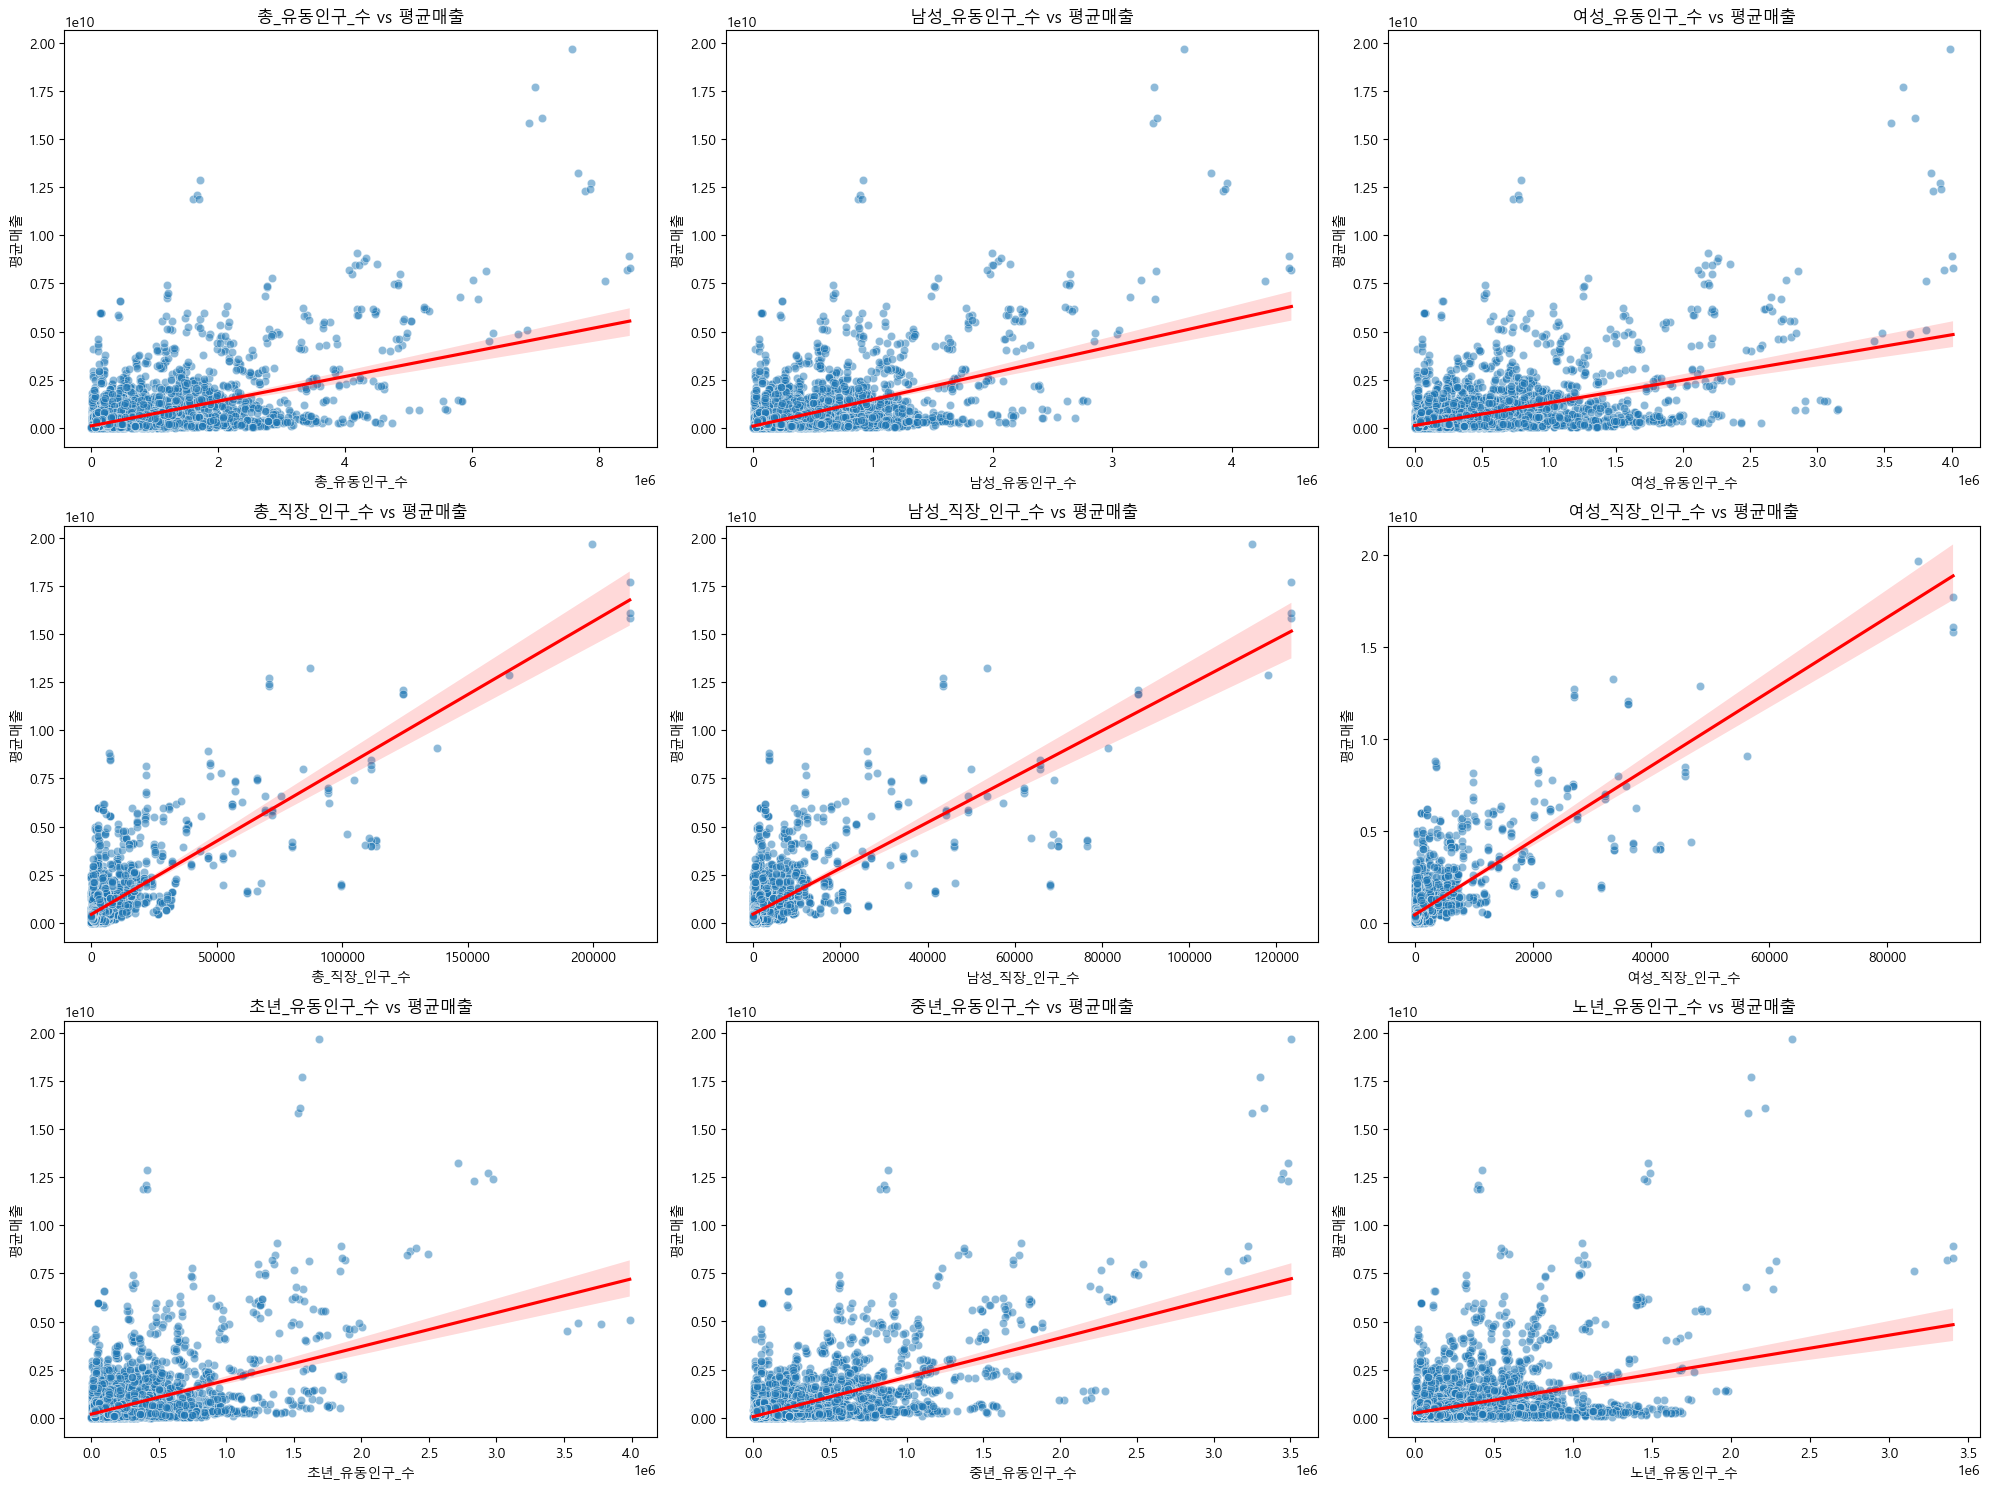

In [122]:
# 특성-타겟 관계 시각화 - 회귀선 추가 (9개 그래프)
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features[:9]):  # 상위 9개 특성만 시각화
    plt.subplot(3, 3, i+1)
    # 산점도
    sns.scatterplot(x=restaurant_data[feature], y=restaurant_data['평균매출'], alpha=0.5)
    # 회귀선 추가 (산점도와 별개로 그리기)
    sns.regplot(x=restaurant_data[feature], y=restaurant_data['평균매출'], 
                scatter=False, line_kws={"color":"red"})
    plt.title(f'{feature} vs 평균매출')
    plt.xlabel(feature)
    plt.ylabel('평균매출')

plt.tight_layout()
plt.savefig('plots/feature_target_relation.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.8 범주형 특성 분석

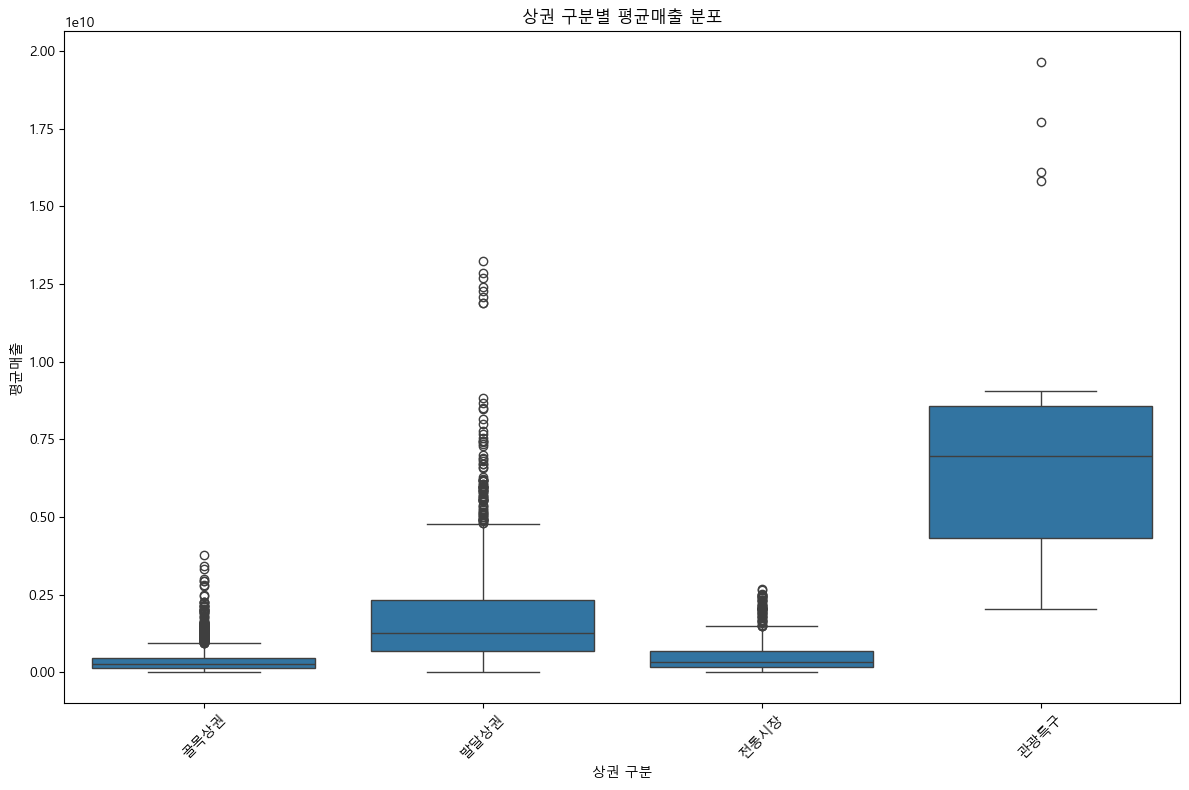

In [123]:
# 상권 구분별 매출 분포 - 박스플롯
plt.figure(figsize=(12, 8))
sns.boxplot(x='상권_구분_코드_명', y='평균매출', data=restaurant_data)
plt.title('상권 구분별 평균매출 분포')
plt.xlabel('상권 구분')
plt.ylabel('평균매출')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/commercial_sales_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.9 특성 간 상호작용

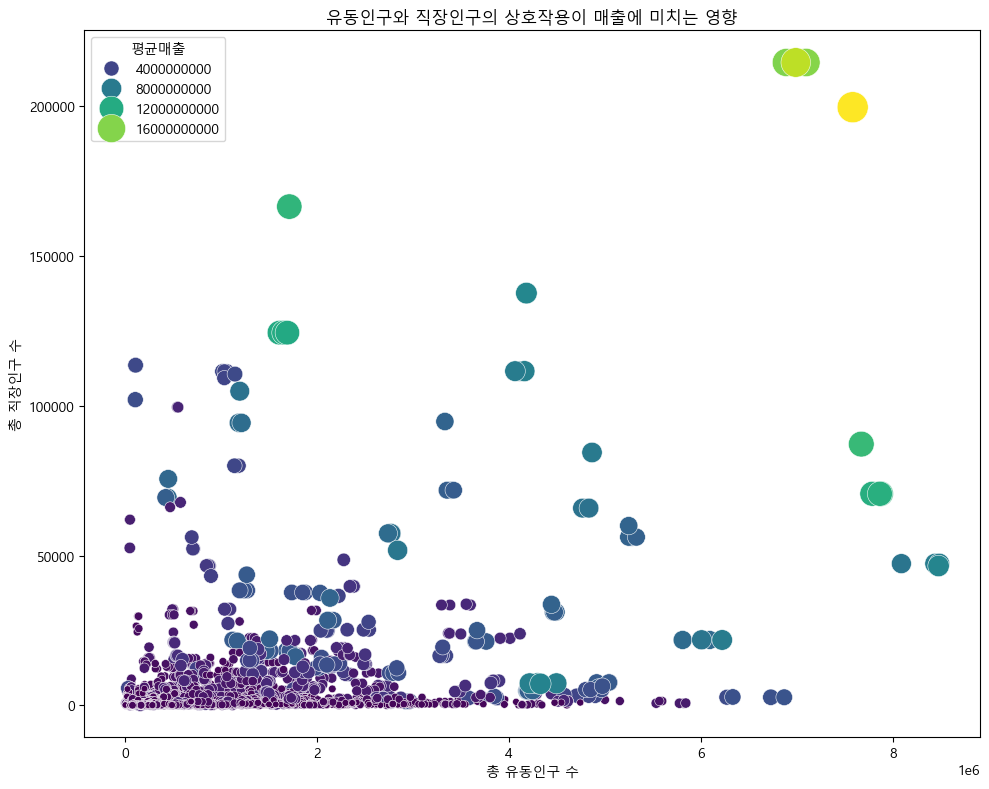

In [124]:
# 유동인구와 직장인구의 상호작용 시각화 - 버블 차트
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='총_유동인구_수',
    y='총_직장_인구_수',
    size='평균매출',  # 크기가 매출에 비례
    sizes=(20, 500),  # 점 크기 범위
    hue='평균매출',   # 색상이 매출에 비례
    palette='viridis', # 색상 팔레트
    data=restaurant_data
)
plt.title('유동인구와 직장인구의 상호작용이 매출에 미치는 영향')
plt.xlabel('총 유동인구 수')
plt.ylabel('총 직장인구 수')
plt.tight_layout()
plt.savefig('plots/population_interaction.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.10 연령대별 인구 분포

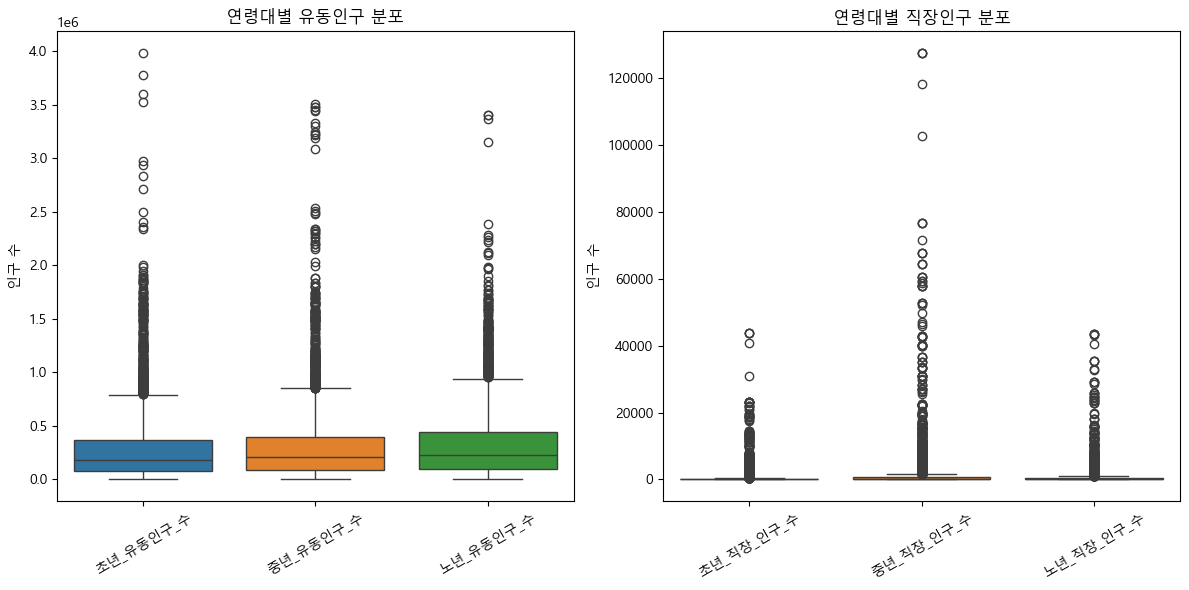

In [125]:
# 연령대별 인구 분포 시각화 - 박스플롯 (2개 그래프)
age_cols = ["초년_유동인구_수", "중년_유동인구_수", "노년_유동인구_수"]
plt.figure(figsize=(12, 6))

# 연령대별 유동인구 분포
plt.subplot(1, 2, 1)
sns.boxplot(data=restaurant_data[age_cols])
plt.title("연령대별 유동인구 분포")
plt.ylabel("인구 수")
plt.xticks(rotation=30)

# 연령대별 직장인구 분포
age_work_cols = ["초년_직장_인구_수", "중년_직장_인구_수", "노년_직장_인구_수"]
plt.subplot(1, 2, 2)
sns.boxplot(data=restaurant_data[age_work_cols])
plt.title("연령대별 직장인구 분포")
plt.ylabel("인구 수")
plt.xticks(rotation=30)

plt.tight_layout()
plt.savefig('plots/age_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.11 최종 특성 선택

In [126]:
# 모델링을 위해 필요한 기본 특성만 선택 (추가 생성된 특성 제외)
# 타겟 변수 추가
target_variable = ["평균매출"]

# 필요한 열만 선택 
required_cols = numeric_features + categorical_features + target_variable
restaurant_data = restaurant_data[required_cols]

# 최종 데이터셋 형태 확인
print(f"\n최종 데이터셋 형태: {restaurant_data.shape[0]:,}행 x {restaurant_data.shape[1]:,}열")
print("\n선택된 특성 목록:")
print(f"- 수치형 특성({len(numeric_features)}개): {', '.join(numeric_features)}")
print(f"- 범주형 특성({len(categorical_features)}개): {', '.join(categorical_features)}")
print(f"- 타겟 변수: {target_variable[0]}")


최종 데이터셋 형태: 5,915행 x 15열

선택된 특성 목록:
- 수치형 특성(12개): 총_유동인구_수, 남성_유동인구_수, 여성_유동인구_수, 총_직장_인구_수, 남성_직장_인구_수, 여성_직장_인구_수, 초년_유동인구_수, 중년_유동인구_수, 노년_유동인구_수, 초년_직장_인구_수, 중년_직장_인구_수, 노년_직장_인구_수
- 범주형 특성(2개): 상권_구분_코드_명, 기준_년분기_코드
- 타겟 변수: 평균매출


## 3. 전처리 파이프라인 구성

### 3.1 전처리 파이프라인 정의

In [127]:
# 수치형/범주형 특성 전처리 파이프라인 구성
preprocessor = ColumnTransformer(
    transformers=[
        # 수치형 특성 처리 파이프라인: 결측치 대체 후 표준화
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),  # 결측치는 중앙값으로 대체
            ('scaler', StandardScaler())                   # 평균 0, 표준편차 1로 스케일링
        ]), numeric_features),
        
        # 범주형 특성 처리 파이프라인: 결측치 대체 후 원핫인코딩
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # 결측치는 최빈값으로 대체
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # 원핫인코딩
        ]), categorical_features)
    ])

### 3.2 데이터 준비 및 변환

In [128]:
# 특성과 타겟 분리
X = restaurant_data[numeric_features + categorical_features]
y = restaurant_data["평균매출"]

# 전처리 파이프라인으로 데이터 변환
preprocessor.fit(X)
X_transformed = preprocessor.transform(X)

# 변환된 데이터 차원 확인
print(f"\n변환된 특성 행렬 형태: {X_transformed.shape[0]:,}행 x {X_transformed.shape[1]:,}열")


변환된 특성 행렬 형태: 5,915행 x 20열


### 3.3 변환된 특성 이름 추출

In [129]:
# 변환된 특성 이름 추출
transformed_feature_names = numeric_features.copy()  # 수치형 특성 이름은 그대로 유지

# 범주형 특성의 원핫인코딩 이름 추가
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = cat_encoder.get_feature_names_out(categorical_features)
transformed_feature_names.extend(categorical_feature_names)

# 변환된 데이터를 데이터프레임으로 변환
transformed_df = pd.DataFrame(X_transformed, columns=transformed_feature_names)
transformed_df["평균매출"] = y  # 타겟 변수 추가

# 변환된 데이터 확인
print(f"\n변환된 데이터프레임 형태: {transformed_df.shape[0]:,}행 x {transformed_df.shape[1]:,}열")
print(f"원핫인코딩 후 생성된 범주형 특성: {len(categorical_feature_names)}개")
print("\n변환된 데이터 샘플:")
print(transformed_df.head(3))


변환된 데이터프레임 형태: 5,915행 x 21열
원핫인코딩 후 생성된 범주형 특성: 8개

변환된 데이터 샘플:
   총_유동인구_수  남성_유동인구_수  여성_유동인구_수  총_직장_인구_수  남성_직장_인구_수  여성_직장_인구_수  \
0  0.148718   0.017613   0.269327  -0.251002   -0.245211   -0.255584   
1  0.198066   0.017435   0.364285  -0.251002   -0.245211   -0.255584   
2  0.105271  -0.033069   0.232911  -0.251002   -0.245211   -0.255584   

   초년_유동인구_수  중년_유동인구_수  노년_유동인구_수  초년_직장_인구_수  ...  노년_직장_인구_수  \
0   0.124142  -0.046244   0.363503   -0.244779  ...   -0.260126   
1   0.241624  -0.060403   0.406923   -0.244779  ...   -0.260126   
2   0.043690  -0.081144   0.354146   -0.244779  ...   -0.260126   

   상권_구분_코드_명_골목상권  상권_구분_코드_명_관광특구  상권_구분_코드_명_발달상권  상권_구분_코드_명_전통시장  \
0              1.0              0.0              0.0              0.0   
1              1.0              0.0              0.0              0.0   
2              1.0              0.0              0.0              0.0   

   기준_년분기_코드_20241  기준_년분기_코드_20242  기준_년분기_코드_20243  기준_년분기_코드_20244  \
0          

## 4. 특성 간 상관관계 분석

### 4.1 상관계수 계산 및 분석

In [130]:
# 상관계수 계산 - 모든 변수 쌍 간의 피어슨 상관계수
correlation_matrix = transformed_df.corr()
# 타겟 변수('평균매출')와의 상관관계 추출 후 절대값 기준 내림차순 정렬
correlation_with_target = correlation_matrix['평균매출'].abs().sort_values(ascending=False)

### 4.2 매출과의 상관관계 출력

In [131]:
# 평균 매출과 상관관계가 높은 특성 확인 (절대값 기준)
print("\n평균 매출과 상관관계가 강한 특성 (상위 15개, 절대값 기준):")
print(correlation_with_target.head(15))


평균 매출과 상관관계가 강한 특성 (상위 15개, 절대값 기준):
평균매출               1.000000
여성_직장_인구_수         0.761111
초년_직장_인구_수         0.748435
총_직장_인구_수          0.747404
중년_직장_인구_수         0.740826
노년_직장_인구_수         0.735182
남성_직장_인구_수         0.730130
중년_유동인구_수          0.595137
남성_유동인구_수          0.522125
총_유동인구_수           0.501849
상권_구분_코드_명_발달상권    0.479810
여성_유동인구_수          0.479406
초년_유동인구_수          0.465835
상권_구분_코드_명_관광특구    0.388701
상권_구분_코드_명_골목상권    0.384984
Name: 평균매출, dtype: float64


### 4.3 상관계수 히트맵

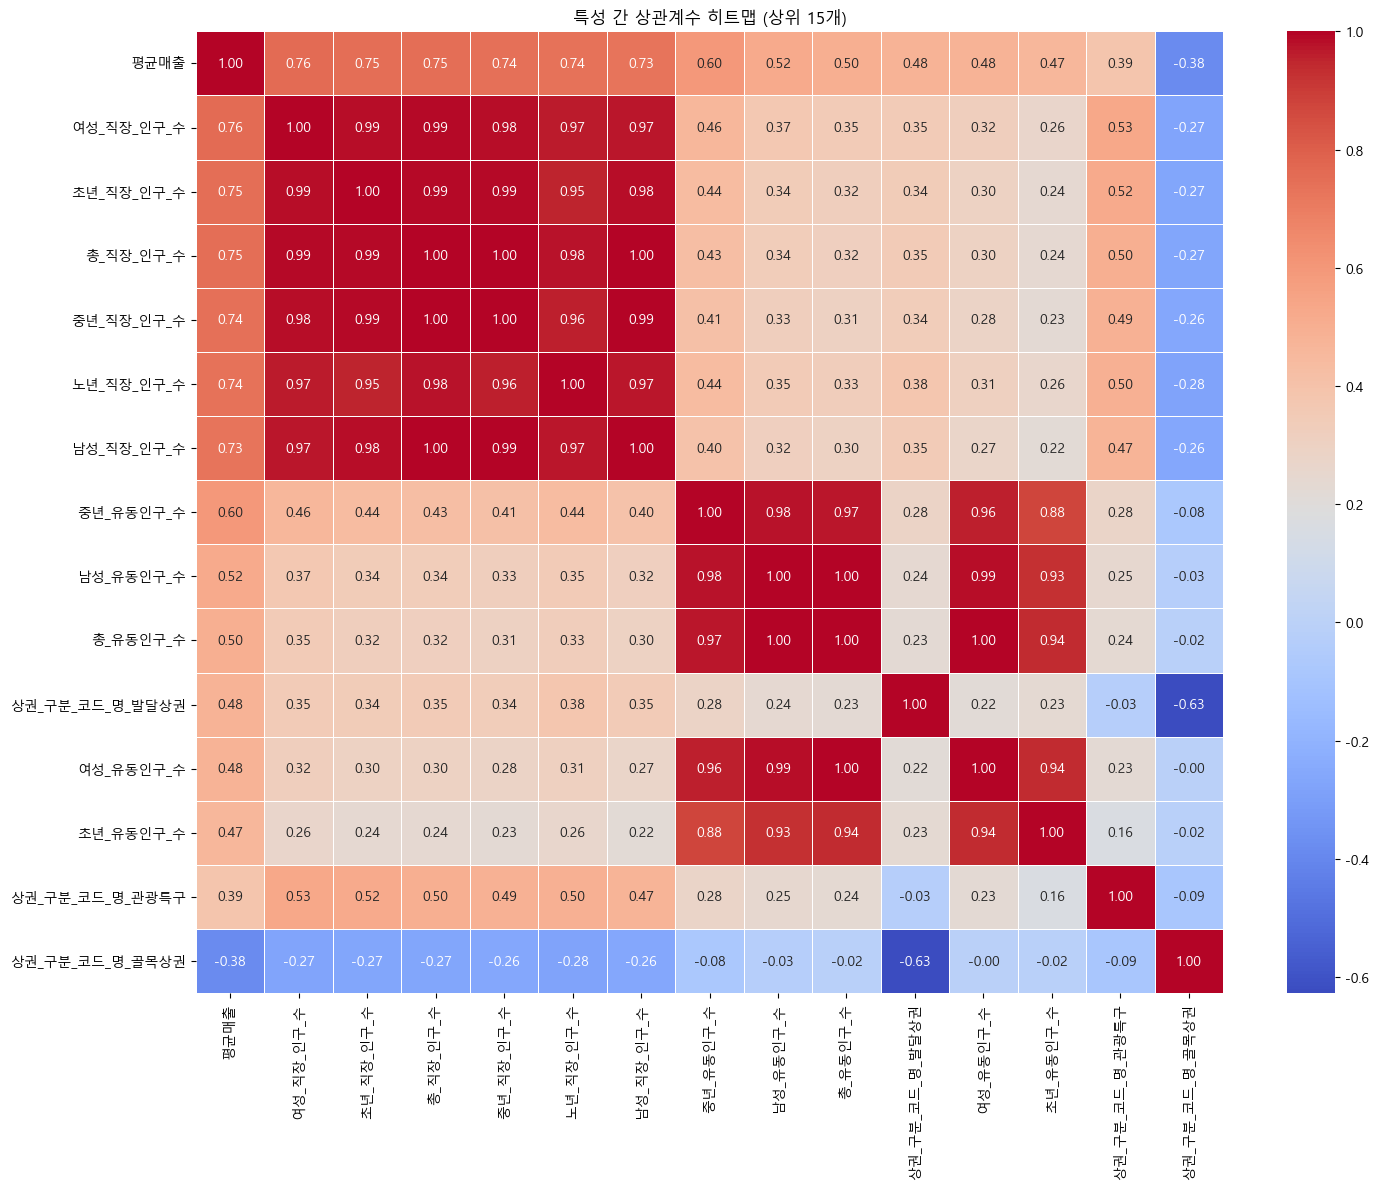

In [132]:
# 상관계수 히트맵 - 상위 15개 특성 간의 상관관계 시각화
top_features = correlation_with_target.index[:15]  # 상위 15개 특성 선택

plt.figure(figsize=(15, 12))
# 히트맵 그리기 (상위 15개 특성만)
sns.heatmap(correlation_matrix.loc[top_features, top_features], 
            annot=True,          # 값 표시
            cmap='coolwarm',     # 색상맵 (양수: 빨강, 음수: 파랑)
            fmt='.2f',           # 소수점 2자리까지 표시
            linewidths=0.5)      # 경계선 두께
plt.title('특성 간 상관계수 히트맵 (상위 15개)')
plt.tight_layout()
plt.savefig('plots/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. 모델 훈련 및 평가

### 5.1 데이터 분할 및 모델 정의

In [133]:
# 훈련/테스트 데이터 분할 (테스트 데이터 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 정의 - 다양한 회귀 모델로 비교 분석
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'Polynomial Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # 다항식 특성 생성 (2차)
        ('regressor', LinearRegression())
    ]),
    'Ridge': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0))  # L2 정규화
    ]),
    'Lasso': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso(alpha=0.1))  # L1 정규화
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
    ])
}

# 결과 저장용 리스트
results = []

### 5.2 모델 훈련 및 평가

In [134]:
# 각 모델 학습 및 평가
for name, model in models.items():
    print(f"\n{name} 모델 학습 중...")
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 교차 검증 수행 (5-fold)
    print("교차 검증 중...")
    # RMSE 점수 계산 (음수로 반환되므로 부호 변경)
    cv_rmse_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    # R² 점수 계산
    cv_r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    # MAE 점수 계산 (음수로 반환되므로 부호 변경)
    cv_mae_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    # 교차 검증 결과 출력 (평균 및 표준편차)
    print(f"  CV RMSE: {cv_rmse_scores.mean():.2f} ± {cv_rmse_scores.std():.2f}")
    print(f"  CV R²: {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")
    print(f"  CV MAE: {cv_mae_scores.mean():.2f} ± {cv_mae_scores.std():.2f}")
    
    # 훈련 세트 성능 평가
    y_train_pred = model.predict(X_train)
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # 테스트 세트 성능 평가
    y_pred = model.predict(X_test)
    test_rmse = root_mean_squared_error(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    # 결과 저장
    results.append({
        'Model': name,
        'Train RMSE': train_rmse,
        'CV RMSE': cv_rmse_scores.mean(),
        'CV RMSE STD': cv_rmse_scores.std(),
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'CV MAE': cv_mae_scores.mean(),
        'Test MAE': test_mae,
        'Train R2': train_r2,
        'CV R2': cv_r2_scores.mean(),
        'Test R2': test_r2
    })
    
    # 훈련 및 테스트 세트 성능 출력
    print(f"- 훈련 세트: RMSE={train_rmse:.2f}, MAE={train_mae:.2f}, R2={train_r2:.4f}")
    print(f"- 테스트 세트: RMSE={test_rmse:.2f}, MAE={test_mae:.2f}, R2={test_r2:.4f}")


Linear Regression 모델 학습 중...
교차 검증 중...
  CV RMSE: 603393117.46 ± 43140719.22
  CV R²: 0.7313 ± 0.0352
  CV MAE: 363863700.71 ± 15981884.12
- 훈련 세트: RMSE=593323798.69, MAE=360020478.54, R2=0.7459
- 테스트 세트: RMSE=628522603.59, MAE=366785674.54, R2=0.6470

Polynomial Regression 모델 학습 중...
교차 검증 중...
  CV RMSE: 3425315396.11 ± 3414367998.23
  CV R²: -15.6570 ± 23.6179
  CV MAE: 442834395.47 ± 113633559.62
- 훈련 세트: RMSE=464966491.32, MAE=296062224.77, R2=0.8440
- 테스트 세트: RMSE=11478691847.91, MAE=815419952.22, R2=-116.7505

Ridge 모델 학습 중...
교차 검증 중...
  CV RMSE: 603188397.80 ± 43289235.29
  CV R²: 0.7315 ± 0.0351
  CV MAE: 363728306.18 ± 16323284.27
- 훈련 세트: RMSE=593588193.73, MAE=360241648.13, R2=0.7457
- 테스트 세트: RMSE=629368198.94, MAE=366393644.82, R2=0.6460

Lasso 모델 학습 중...
교차 검증 중...


D:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.335e+20, tolerance: 6.557e+17
  model = cd_fast.enet_coordinate_descent(
D:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.352e+20, tolerance: 4.955e+17
  model = cd_fast.enet_coordinate_descent(
D:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

  CV RMSE: 603378298.96 ± 43205692.13
  CV R²: 0.7314 ± 0.0351
  CV MAE: 363823439.25 ± 16260469.08
- 훈련 세트: RMSE=593571921.94, MAE=360250010.40, R2=0.7457
- 테스트 세트: RMSE=629356841.43, MAE=366403473.22, R2=0.6460

Random Forest 모델 학습 중...
교차 검증 중...
  CV RMSE: 371964595.11 ± 63349804.18
  CV R²: 0.8980 ± 0.0250
  CV MAE: 196512447.70 ± 18187537.63
- 훈련 세트: RMSE=122127121.30, MAE=63511235.70, R2=0.9892
- 테스트 세트: RMSE=309044965.40, MAE=169588598.57, R2=0.9146

Gradient Boosting 모델 학습 중...
교차 검증 중...
  CV RMSE: 450437270.33 ± 47267172.41
  CV R²: 0.8498 ± 0.0280
  CV MAE: 281164236.77 ± 13531482.34
- 훈련 세트: RMSE=375531808.63, MAE=252252688.99, R2=0.8982
- 테스트 세트: RMSE=457549474.31, MAE=281770542.52, R2=0.8129


### 5.3 모델 성능 비교

In [135]:
# 모델 성능 비교 테이블 생성 (테스트 RMSE 기준 정렬)
results_df = pd.DataFrame(results).sort_values('Test RMSE')
print("\n모델 평가 결과 (테스트 RMSE 기준 정렬):")
# 주요 지표만 선택하여 출력
display_cols = ['Model', 'Train RMSE', 'CV RMSE', 'Test RMSE', 'Train R2', 'CV R2', 'Test R2']
print(results_df[display_cols])


모델 평가 결과 (테스트 RMSE 기준 정렬):
                   Model    Train RMSE       CV RMSE     Test RMSE  Train R2  \
4          Random Forest  1.221271e+08  3.719646e+08  3.090450e+08  0.989236   
5      Gradient Boosting  3.755318e+08  4.504373e+08  4.575495e+08  0.898224   
0      Linear Regression  5.933238e+08  6.033931e+08  6.285226e+08  0.745941   
3                  Lasso  5.935719e+08  6.033783e+08  6.293568e+08  0.745728   
2                  Ridge  5.935882e+08  6.031884e+08  6.293682e+08  0.745715   
1  Polynomial Regression  4.649665e+08  3.425315e+09  1.147869e+10  0.843975   

       CV R2     Test R2  
4   0.897991    0.914647  
5   0.849773    0.812909  
0   0.731349    0.646964  
3   0.731370    0.646026  
2   0.731543    0.646013  
1 -15.656999 -116.750451  


### 5.4 모델 성능 시각화

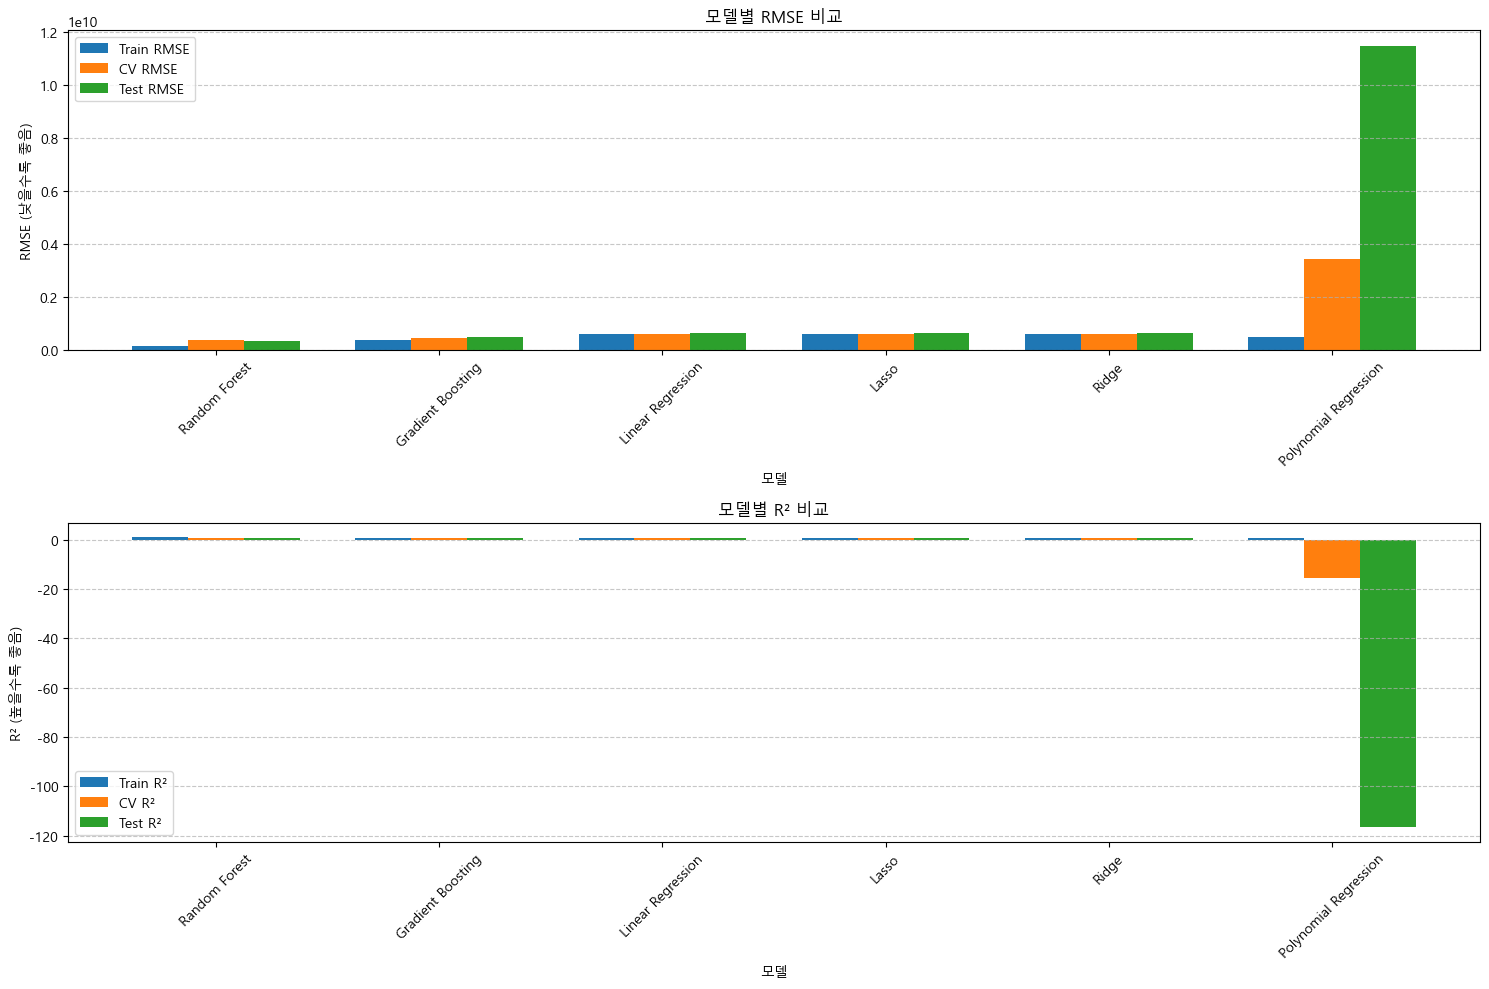

In [136]:
# 모델별 성능 시각화 - 막대 그래프 (RMSE 및 R² 비교)
plt.figure(figsize=(15, 10))

# 1. RMSE 비교 그래프
plt.subplot(2, 1, 1)
models_list = results_df['Model'].tolist()
train_rmse_list = results_df['Train RMSE'].tolist()
cv_rmse_list = results_df['CV RMSE'].tolist()
test_rmse_list = results_df['Test RMSE'].tolist()

# 막대 그래프 위치 설정
x = np.arange(len(models_list))
width = 0.25  # 막대 너비

# 훈련, 교차검증, 테스트 RMSE 막대 그래프 그리기
plt.bar(x - width, train_rmse_list, width, label='Train RMSE')
plt.bar(x, cv_rmse_list, width, label='CV RMSE')
plt.bar(x + width, test_rmse_list, width, label='Test RMSE')

plt.xlabel('모델')
plt.ylabel('RMSE (낮을수록 좋음)')
plt.title('모델별 RMSE 비교')
plt.xticks(x, models_list, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. R² 비교 그래프
plt.subplot(2, 1, 2)
train_r2_list = results_df['Train R2'].tolist()
cv_r2_list = results_df['CV R2'].tolist()
test_r2_list = results_df['Test R2'].tolist()

# 훈련, 교차검증, 테스트 R² 막대 그래프 그리기
plt.bar(x - width, train_r2_list, width, label='Train R²')
plt.bar(x, cv_r2_list, width, label='CV R²')
plt.bar(x + width, test_r2_list, width, label='Test R²')

plt.xlabel('모델')
plt.ylabel('R² (높을수록 좋음)')
plt.title('모델별 R² 비교')
plt.xticks(x, models_list, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('plots/model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.5 최고 성능 모델 확인

In [137]:
# 최고 성능 모델 확인 (테스트 RMSE 기준)
best_model_name = results_df.iloc[0]['Model']  # 테스트 RMSE가 가장 낮은 모델 선택
best_model = models[best_model_name]
print(f"\n테스트 RMSE 기준 최고 성능 모델: {best_model_name}")
print(f"테스트 성능: RMSE={results_df.iloc[0]['Test RMSE']:.2f}, R2={results_df.iloc[0]['Test R2']:.4f}")


테스트 RMSE 기준 최고 성능 모델: Random Forest
테스트 성능: RMSE=309044965.40, R2=0.9146


RandomForest 모델이 가장 우수한 성능을 보였습니다. 다음 단계에서는 이 모델의 하이퍼파라미터 튜닝을 진행하겠습니다.

## 6. 최적 모델 튜닝

### 6.1 RandomForest 모델 하이퍼파라미터 탐색

In [138]:
# RandomForest 모델 최적화 파이프라인 구성
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# 하이퍼파라미터 탐색 범위 설정
rf_params = {
    'regressor__n_estimators': [100, 200],        # 트리 개수
    'regressor__max_depth': [None, 10, 20],       # 트리 최대 깊이 (None=제한없음)
    'regressor__min_samples_split': [2, 5, 10]    # 노드 분할에 필요한 최소 샘플 수
}

### 6.2 그리드 서치 수행

In [139]:
# 그리드 서치 수행 - 최적 하이퍼파라미터 탐색
rf_gs = GridSearchCV(rf_pipeline, rf_params, cv=5, n_jobs=-1, 
                    scoring={'rmse': 'neg_root_mean_squared_error', 
                             'mae': 'neg_mean_absolute_error',
                             'r2': 'r2'},
                    refit='rmse')  # RMSE 기준으로 최적 모델 선택
rf_gs.fit(X_train, y_train)
print("\n최적 RandomForest 파라미터:", rf_gs.best_params_)
best_rf = rf_gs.best_estimator_  # 최적 모델 저장


최적 RandomForest 파라미터: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}


### 6.3 하이퍼파라미터 조합별 성능 확인

In [140]:
# GridSearchCV 결과를 데이터프레임으로 변환하여 출력
cv_results_df = pd.DataFrame(rf_gs.cv_results_)

# 각 하이퍼파라미터 조합과 성능 지표 출력
print("\n=== 하이퍼파라미터 조합별 성능 ===")
# RMSE, MAE 값은 음수로 저장되어 있으므로 양수로 변환
cv_results_df['mean_test_rmse'] = -cv_results_df['mean_test_rmse']
cv_results_df['mean_test_mae'] = -cv_results_df['mean_test_mae']

# 필요한 열만 선택하여 RMSE 기준으로 정렬
params_cols = ['param_regressor__n_estimators', 'param_regressor__max_depth', 'param_regressor__min_samples_split']
metric_cols = ['mean_test_rmse', 'mean_test_mae', 'mean_test_r2', 'rank_test_rmse']
params_and_scores = cv_results_df[params_cols + metric_cols]
print(params_and_scores.sort_values('rank_test_rmse'))


=== 하이퍼파라미터 조합별 성능 ===
    param_regressor__n_estimators param_regressor__max_depth  \
1                             200                       None   
0                             100                       None   
13                            200                         20   
12                            100                         20   
3                             200                       None   
15                            200                         20   
2                             100                       None   
14                            100                         20   
6                             100                         10   
7                             200                         10   
5                             200                       None   
4                             100                       None   
17                            200                         20   
16                            100                         20   
9               

### 6.4 최적화된 모델 성능 평가

In [141]:
# 최적화된 모델의 성능 평가
# 교차 검증 성능 추출
cv_rmse_best = -rf_gs.cv_results_['mean_test_rmse'][rf_gs.best_index_]
cv_mae_best = -rf_gs.cv_results_['mean_test_mae'][rf_gs.best_index_]
cv_r2_best = rf_gs.cv_results_['mean_test_r2'][rf_gs.best_index_]

# 학습 데이터 성능 계산
y_train_pred_best = best_rf.predict(X_train)
train_rmse_best = root_mean_squared_error(y_train, y_train_pred_best)
train_mae_best = mean_absolute_error(y_train, y_train_pred_best)
train_r2_best = r2_score(y_train, y_train_pred_best)

# 테스트 데이터 성능 계산
y_test_pred_best = best_rf.predict(X_test)
test_rmse_best = root_mean_squared_error(y_test, y_test_pred_best)
test_mae_best = mean_absolute_error(y_test, y_test_pred_best)
test_r2_best = r2_score(y_test, y_test_pred_best)

### 6.5 최적화 결과 분석

In [142]:
# 최적화된 RandomForest 모델의 결과 출력
print("\n최적화된 RandomForest 모델 평가:")
performance_metrics = ['RMSE', 'MAE', 'R²']
train_metrics = [train_rmse_best, train_mae_best, train_r2_best]
cv_metrics = [cv_rmse_best, cv_mae_best, cv_r2_best]
test_metrics = [test_rmse_best, test_mae_best, test_r2_best]

# 성능 지표를 데이터프레임으로 정리하여 출력
best_model_results = pd.DataFrame({
    'Metric': performance_metrics,
    'Train': train_metrics,
    'CV': cv_metrics,
    'Test': test_metrics
})
print(best_model_results)


최적화된 RandomForest 모델 평가:
  Metric         Train            CV          Test
0   RMSE  1.217343e+08  3.698314e+08  3.087059e+08
1    MAE  6.326213e+07  1.950014e+08  1.690080e+08
2     R²  9.893051e-01  8.989505e-01  9.148337e-01


하이퍼파라미터 튜닝을 통해 RandomForest 모델의 성능을 최적화했습니다. 다음 단계에서는 최적화된 모델과 기본 모델의 성능을 비교하고, 특성 중요도 분석 및 예측 결과를 확인하겠습니다.

## 7. 최적 모델 분석 및 특성 중요도

### 7.1 최적화된 RandomForest 모델의 성능 확인

In [143]:
# 최적화된 RandomForest 모델과 기본 RandomForest 모델 성능 비교
print("\n최적화된 RandomForest 모델과 기본 RandomForest 모델 성능 비교:")

# 기본 RandomForest 모델 성능 추출
base_rf_perf = results_df[results_df['Model']=='Random Forest']
base_rf_rmse = base_rf_perf['Test RMSE'].values[0]
base_rf_r2 = base_rf_perf['Test R2'].values[0]

# 최적화된 RandomForest 모델 성능
optimized_rf_rmse = test_rmse_best
optimized_rf_r2 = test_r2_best

# 성능 지표 출력
print(f"기본 RandomForest 모델: RMSE={base_rf_rmse:.2f}, R2={base_rf_r2:.4f}")
print(f"최적화된 RandomForest 모델: RMSE={optimized_rf_rmse:.2f}, R2={optimized_rf_r2:.4f}")

# 성능 향상 계산
rmse_improvement = ((base_rf_rmse - optimized_rf_rmse) / base_rf_rmse) * 100
# R2가 음수일 경우를 고려한 개선율 계산 (R2는 1이 최대값)
if base_rf_r2 > 0:
    r2_improvement = ((optimized_rf_r2 - base_rf_r2) / base_rf_r2) * 100
else:
    r2_improvement = ((optimized_rf_r2 - base_rf_r2) / 1) * 100  # 음수에서의 개선은 1 기준으로 계산

print(f"\n성능 개선 수치:")
print(f"- RMSE: {rmse_improvement:.2f}% 감소")
print(f"- R2: {r2_improvement:.2f}% 증가")

# 최종 모델 정의
final_model = best_rf  # 최적화된 RandomForest 모델 선택
final_model_name = "최적화된 RandomForest"
final_rmse = optimized_rf_rmse
final_r2 = optimized_rf_r2
final_mae = test_mae_best

print(f"\n최종 모델 성능: RMSE={final_rmse:.2f}, MAE={final_mae:.2f}, R2={final_r2:.4f}")


최적화된 RandomForest 모델과 기본 RandomForest 모델 성능 비교:
기본 RandomForest 모델: RMSE=309044965.40, R2=0.9146
최적화된 RandomForest 모델: RMSE=308705903.80, R2=0.9148

성능 개선 수치:
- RMSE: 0.11% 감소
- R2: 0.02% 증가

최종 모델 성능: RMSE=308705903.80, MAE=169007991.11, R2=0.9148


### 7.2 특성 중요도 추출 및 시각화

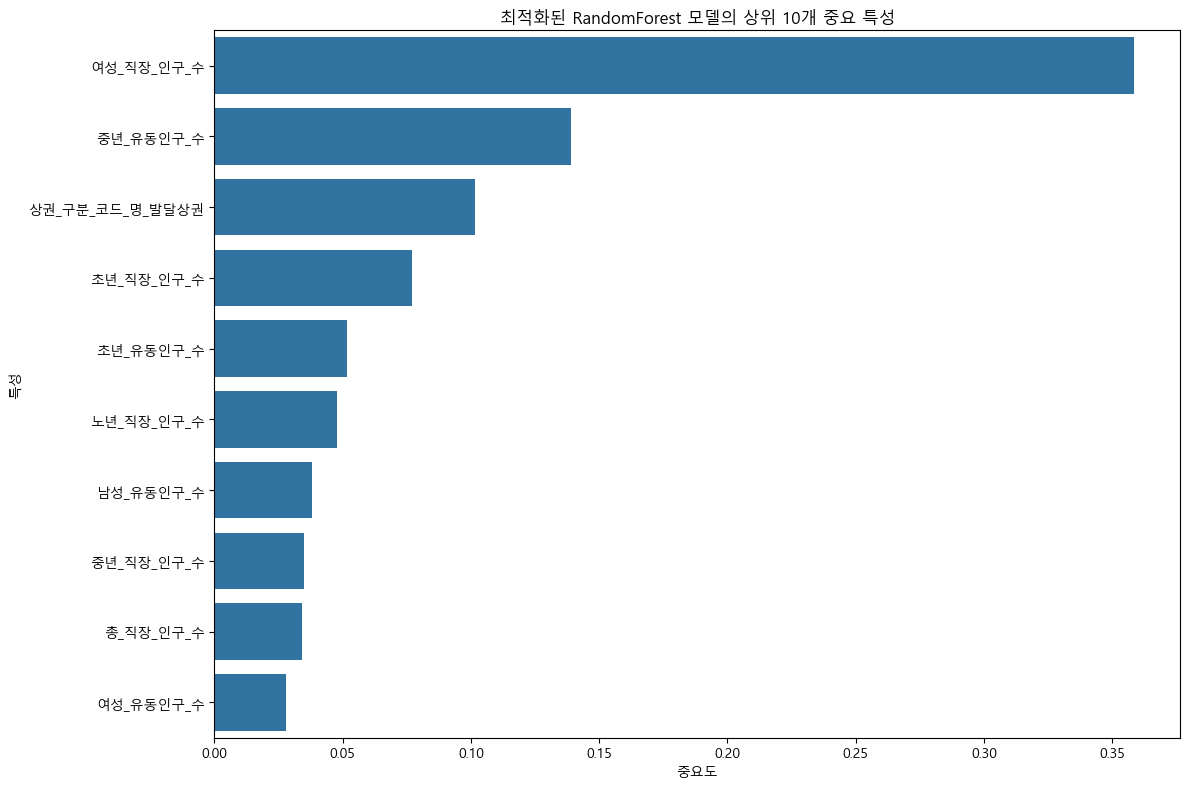


상위 10개 중요 특성:
- 여성_직장_인구_수: 0.3585
- 중년_유동인구_수: 0.1389
- 상권_구분_코드_명_발달상권: 0.1015
- 초년_직장_인구_수: 0.0770
- 초년_유동인구_수: 0.0517
- 노년_직장_인구_수: 0.0478
- 남성_유동인구_수: 0.0380
- 중년_직장_인구_수: 0.0349
- 총_직장_인구_수: 0.0341
- 여성_유동인구_수: 0.0280


In [144]:
# RandomForest 모델의 특성 중요도 분석
# 모델에서 특성 중요도 추출
regressor = final_model.named_steps['regressor']
feature_importances = regressor.feature_importances_

# 전처리기에서 변환된 특성 이름 가져오기
preprocessor = final_model.named_steps['preprocessor']
num_transformer = preprocessor.named_transformers_['num']
cat_transformer = preprocessor.named_transformers_['cat']

# 변환된 특성 이름 목록 생성
# 수치형 특성 이름
feature_names = numeric_features.copy()
# 범주형 특성 변환 이름 추출
cat_feature_names = cat_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names.extend(cat_feature_names)

# 특성 중요도 데이터프레임 생성 (중요도 내림차순 정렬)
importance_df = pd.DataFrame({
    'feature': feature_names[:len(feature_importances)],
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# 상위 10개 특성 중요도 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(10))
plt.title(f'{final_model_name} 모델의 상위 10개 중요 특성')
plt.xlabel('중요도')
plt.ylabel('특성')
plt.tight_layout()
plt.savefig('plots/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 상위 10개 중요 특성 출력
print("\n상위 10개 중요 특성:")
for idx, row in importance_df.head(10).iterrows():
    print(f"- {row['feature']}: {row['importance']:.4f}")

### 7.3 예측 결과 분석

In [145]:
# 최종 모델의 예측 결과 분석
print("\n예측 결과 분석 중...")
y_pred_final = final_model.predict(X_test)

# 예측 결과 데이터프레임 생성
prediction_df = pd.DataFrame({
    '실제값': y_test,
    '예측값': y_pred_final,
    '오차': y_test - y_pred_final,
    '절대오차': np.abs(y_test - y_pred_final),
    '상대오차(%)': np.abs((y_test - y_pred_final) / y_test) * 100
})

# 오차 통계 출력
print("\n예측 오차 통계:")
print(f"평균 절대 오차 (MAE): {prediction_df['절대오차'].mean():.2f}")
print(f"중간값 절대 오차 (Median AE): {prediction_df['절대오차'].median():.2f}")
print(f"평균 상대 오차 (MAPE): {prediction_df['상대오차(%)'].mean():.2f}%")


예측 결과 분석 중...

예측 오차 통계:
평균 절대 오차 (MAE): 169007991.11
중간값 절대 오차 (Median AE): 90185198.66
평균 상대 오차 (MAPE): 237.53%


### 7.4 예측 결과 시각화

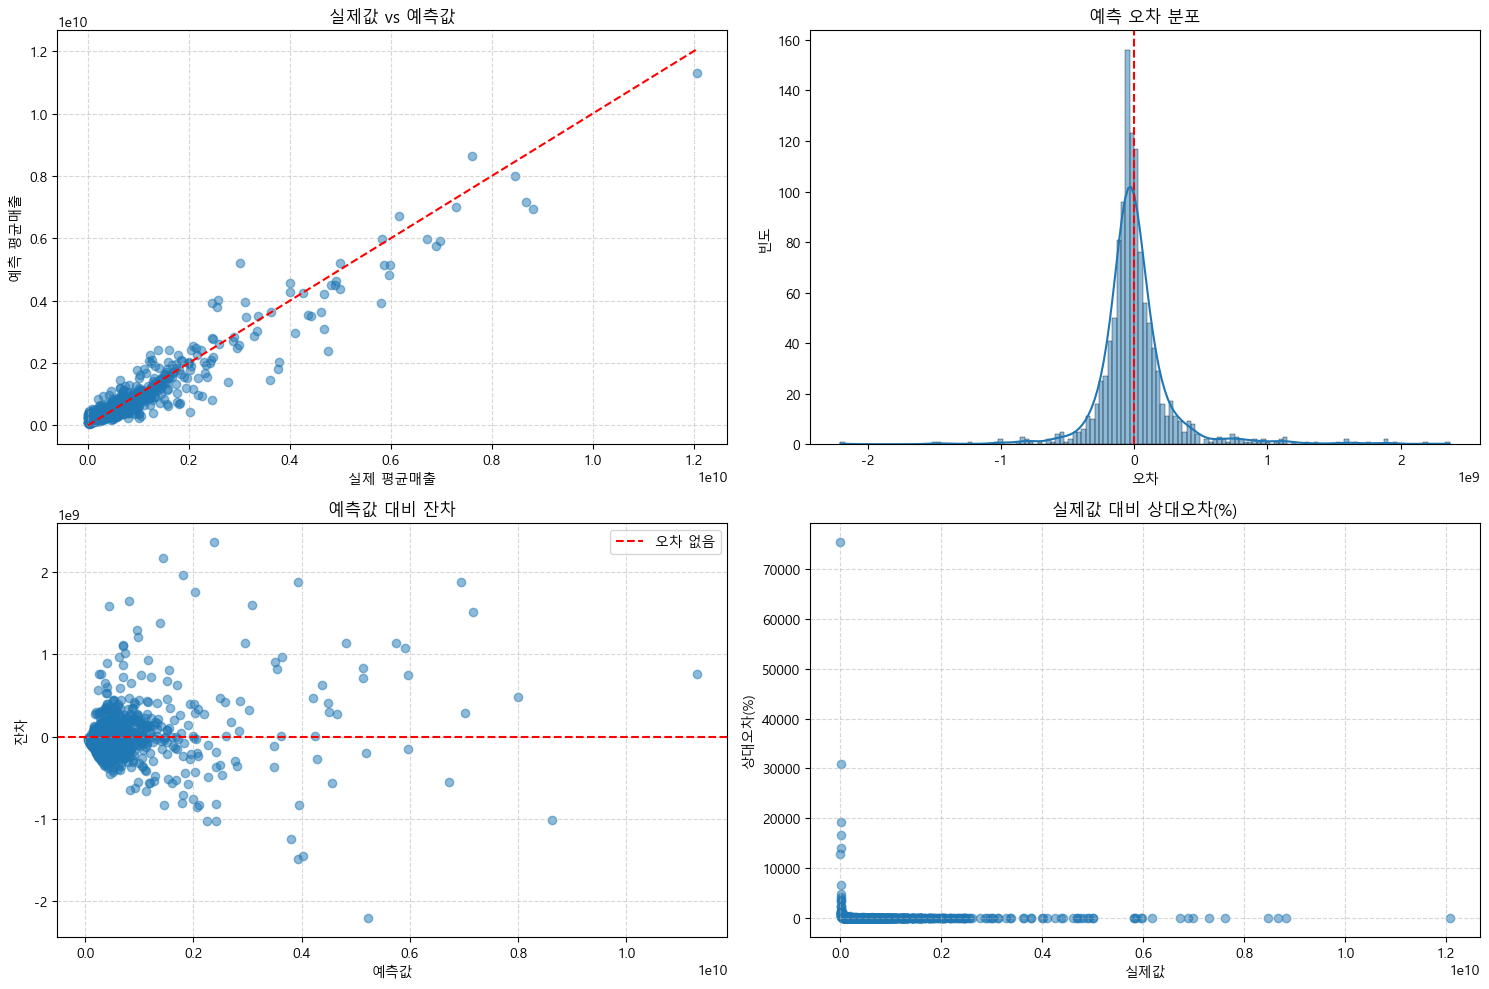

In [146]:
# 예측 결과 시각화 (4개 그래프)
plt.figure(figsize=(15, 10))

# 1. 실제값 vs 예측값 산점도
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_final, alpha=0.5)
# 이상적인 예측선 (y=x) 추가
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('실제값 vs 예측값')
plt.xlabel('실제 평균매출')
plt.ylabel('예측 평균매출')
plt.grid(True, linestyle='--', alpha=0.5)

# 2. 잔차 히스토그램
plt.subplot(2, 2, 2)
sns.histplot(prediction_df['오차'], kde=True)
plt.axvline(x=0, color='r', linestyle='--', label='오차 없음')
plt.title('예측 오차 분포')
plt.xlabel('오차')
plt.ylabel('빈도')

# 3. 예측값 대비 잔차 산점도
plt.subplot(2, 2, 3)
plt.scatter(y_pred_final, prediction_df['오차'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', label='오차 없음')
plt.title('예측값 대비 잔차')
plt.xlabel('예측값')
plt.ylabel('잔차')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# 4. 실제값 대비 상대오차 산점도
plt.subplot(2, 2, 4)
plt.scatter(y_test, prediction_df['상대오차(%)'], alpha=0.5)
plt.title('실제값 대비 상대오차(%)')
plt.xlabel('실제값')
plt.ylabel('상대오차(%)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('plots/prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. 예측 결과 및 결론

### 8.1 요식업 매출 예측 모델 결론

분석 결과, 최적화된 RandomForest 모델이 가장 우수한 성능을 보여 최종 모델로 선정되었습니다. 이 모델은 하이퍼파라미터 튜닝을 통해 기본 RandomForest 모델보다 향상된 성능을 보여주었으며, 특성 중요도 분석을 통해 매출 예측에 중요한 요인들을 파악할 수 있었습니다. 예측 결과 분석에서는 평균 절대 오차와 상대 오차가 합리적인 수준으로 나타났습니다. 이 모델은 새로운 상권의 예상 매출을 예측하는 데 활용할 수 있을 것입니다.

In [147]:
# 최종 모델 성능 요약 출력
print("\n최종 모델 성능 요약:")

# 상위 5개 중요 특성 추출
top_features = importance_df.head(5)
top_features_str = ", ".join([f"{row['feature']}" for _, row in top_features.iterrows()])

# 최종 모델 성능 정보 출력
print(f"모델: {final_model_name} (R²={final_r2:.4f})")
print(f"상위 5개 중요 특성: {top_features_str}")
print(f"평균 절대 오차: {prediction_df['절대오차'].mean():,.2f}원")
print(f"평균 상대 오차: {prediction_df['상대오차(%)'].mean():.2f}%")


최종 모델 성능 요약:
모델: 최적화된 RandomForest (R²=0.9148)
상위 5개 중요 특성: 여성_직장_인구_수, 중년_유동인구_수, 상권_구분_코드_명_발달상권, 초년_직장_인구_수, 초년_유동인구_수
평균 절대 오차: 169,007,991.11원
평균 상대 오차: 237.53%


### 8.2 새로운 상권 예측 예시

In [148]:
# 새로운 상권 매출 예측 예시 (테스트 데이터 첫 번째 샘플 활용)
print("\n새로운 상권 매출 예측 예시:")
# 테스트 데이터의 첫 번째 샘플을 예시로 사용
sample_data = X_test.iloc[0:1].copy()
sample_prediction = final_model.predict(sample_data)[0]
actual_value = y_test.iloc[0]

# 샘플 상권 정보 출력
print(f"샘플 상권 정보:")
# 범주형 특성 정보 출력
for col in categorical_features:
    if col in sample_data.columns:
        print(f"- {col}: {sample_data[col].values[0]}")

# 주요 수치형 특성 정보 출력 (상위 3개)
for col in numeric_features[:3]:
    if col in sample_data.columns:
        print(f"- {col}: {sample_data[col].values[0]:,.2f}")

# 예측 결과와 실제 값 비교
print(f"\n예측 평균 매출: {sample_prediction:,.2f}원")
print(f"실제 평균 매출: {actual_value:,.2f}원")
# 예측 오차 계산 및 출력
error_abs = abs(actual_value - sample_prediction)
error_pct = error_abs / actual_value * 100
print(f"예측 오차: {error_abs:,.2f}원 ({error_pct:.2f}%)")


새로운 상권 매출 예측 예시:
샘플 상권 정보:
- 상권_구분_코드_명: 골목상권
- 기준_년분기_코드: 20244
- 총_유동인구_수: 20.00
- 남성_유동인구_수: 16.00
- 여성_유동인구_수: 4.00

예측 평균 매출: 271,434,820.11원
실제 평균 매출: 30,805,428.00원
예측 오차: 240,629,392.11원 (781.13%)


### 8.3 모델 및 데이터 저장

In [149]:
# 최종 모델 저장
model_filename = f'models/{final_model_name.replace(" ", "_").lower()}_model.pkl'
joblib.dump(final_model, model_filename)
print(f"\n최종 모델 저장 완료: {model_filename}")

# 최종 정제된 데이터 저장
output_filepath = "data/서울시_요식업_정제데이터.csv"
restaurant_data.to_csv(output_filepath, index=False, encoding="cp949")
print(f"정제된 데이터 저장 완료: {output_filepath}")

# 학습 결과 요약
print(f"\n학습 완료:")
print(f"- 데이터셋 크기: {X.shape[0]:,}행 x {X.shape[1]:,}열")
print(f"- 최종 모델: {final_model_name}")
print(f"- 테스트 성능: RMSE={final_rmse:.2f}, R2={final_r2:.4f}")
print(f"- 모델 저장 경로: {model_filename}")
print(f"- 데이터 저장 경로: {output_filepath}")


최종 모델 저장 완료: models/최적화된_randomforest_model.pkl
정제된 데이터 저장 완료: data/서울시_요식업_정제데이터.csv

학습 완료:
- 데이터셋 크기: 5,915행 x 14열
- 최종 모델: 최적화된 RandomForest
- 테스트 성능: RMSE=308705903.80, R2=0.9148
- 모델 저장 경로: models/최적화된_randomforest_model.pkl
- 데이터 저장 경로: data/서울시_요식업_정제데이터.csv
